In [1]:
import pandas as pd 
import numpy as np
import math
import keras
import tensorflow as tf
import progressbar
import os
from os import listdir

## Print Dependencies



Dependences are fundamental to record the computational environment.

Tedstasdf

In [2]:
%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p pandas,keras,numpy,math,tensorflow,matplotlib,h5py

# date
print (" ")
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.23.1

pandas    : 1.2.3
keras     : 2.4.3
numpy     : 1.19.5
math      : unknown
tensorflow: 2.5.0
matplotlib: 3.4.2
h5py      : 3.1.0

Compiler    : Clang 12.0.0 (clang-1200.0.32.29)
OS          : Darwin
Release     : 19.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

 
Last updated: Thu Jul 22 2021 15:26:06WEST



## Load of the data

   You can also load all of them! Writing "all_data"

In [51]:
from process import loaddata

### Data-set loading for low energy

In [102]:
class_data_low0 = loaddata("../data/{}.csv".format('high_ene'))
class_data_low0 = class_data_low0[class_data_low0[:,0] > 0.001 ]
class_data_low = class_data_low0

### Data-set loading for high energy

In [54]:
class_data_high0 = loaddata("../data/{}.csv".format('weight'))
class_data_high1 = class_data_high0[class_data_high0[:,0] > 0.001 ]
class_data_high = class_data_high1[class_data_high1[:,0] < 0.013 ]

In [ ]:
def balance_data(class_data, nbins):

    from matplotlib import pyplot as plt
    y = class_data[:,0]
    n, edges, _ = plt.hist(y, nbins, color = 'indianred', alpha=0.5, label='Osiris')
    n_max = int(n.max()/10.)
    data = []
    bar = progressbar.ProgressBar(maxval=len(class_data), 
                              widgets=[progressbar.Bar('=', '[', ']'), ' ', 
                                       progressbar.Percentage(), 
                                       " of {0}".format(len(class_data))])
    bar.start()
    for k, class_ in enumerate(class_data):
        for i in range(len(n)):
            edges_min = edges[i]
            edges_max = edges[i+1]
            if class_[0] > edges_min and class_[0] < edges_max:
                for j in range(int(n_max/(n[i]))):
                    data.append(class_)
                break
        bar.update(k+1)
    bar.finish()

    return np.array(data)

In [103]:
class_data_low.shape

(106671, 14)

In [ ]:
class_data_high.shape

[==============================================================] 100% of 257721


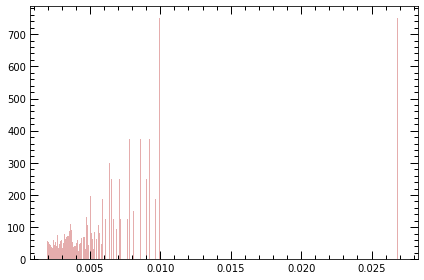

In [114]:
class_data_low = balance_data(class_data_low, 10000)

In [ ]:
class_data_high = balance_data(class_data_high, 1000)

In [115]:
np.random.shuffle(class_data_low)
y0 = class_data_low[:,0]
x0 = class_data_low[:,1:9]
np.isnan(np.min(y0))

False

In [61]:
print(y0.shape)
print(x0.shape)

(6341581,)
(6341581, 8)


In [62]:
np.random.shuffle(class_data_high)
y1 = class_data_high[:,0]
x1 = class_data_high[:,1:9]

In [63]:
print(y1.shape)
print(x1.shape)

(63754,)
(63754, 8)


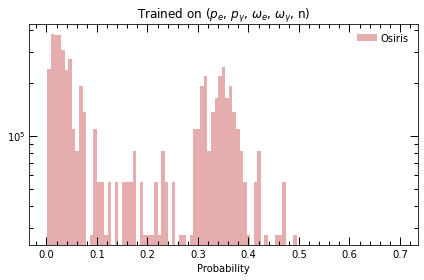

In [64]:
from matplotlib import pyplot
y0 = np.array(y0)
bins = np.linspace(0.001, 0.7, 100)
pyplot.hist(y0, bins, color = 'indianred', alpha=0.5, label='Osiris')
pyplot.legend(loc='upper right')
pyplot.xlabel('Probability')
pyplot.yscale('log')
pyplot.title('Trained on ($p_e$, $p_{\gamma}$, $\omega_e$, $\omega_{\gamma}$, n)')
pyplot.show()

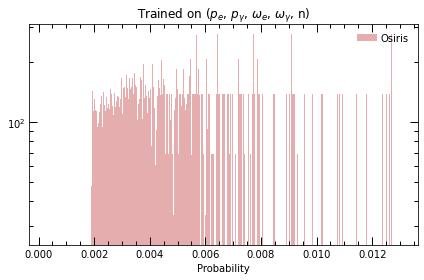

In [65]:
from matplotlib import pyplot
y1 = np.array(y1)
bins = np.linspace(0.0003, 0.013, 1000)
pyplot.hist(y1, bins, color = 'indianred', alpha=0.5, label='Osiris')
pyplot.legend(loc='upper right')
pyplot.xlabel('Probability')
pyplot.yscale('log')
pyplot.title('Trained on ($p_e$, $p_{\gamma}$, $\omega_e$, $\omega_{\gamma}$, n)')
pyplot.show()

In [116]:
train_split0 = 0.85
train_limit0 = int(len(y0)*train_split0)
print("Training sample: {0} \nValuation sample: {1}".format(train_limit0, len(y0)-train_limit0))

Training sample: 50348 
Valuation sample: 8886


In [117]:
x_train0 = x0[:train_limit0]
x_val0 = x0[train_limit0:]

y_train0 = y0[:train_limit0]
y_val0 = y0[train_limit0:]

In [84]:
train_split1 = 0.85
train_limit1 = int(len(y1)*train_split1)
print("Training sample: {0} \nValuation sample: {1}".format(train_limit1, len(y1)-train_limit1))

Training sample: 38618 
Valuation sample: 6815


In [85]:
x_train1 = x1[:train_limit1]
x_val1 = x1[train_limit1:]

y_train1 = y1[:train_limit1]
y_val1 = y1[train_limit1:]

## Model Build

In [86]:
from keras.models import Sequential
from keras.layers.core import Dense
import keras.backend as K
from keras import optimizers
from keras import models
from keras import layers
from keras.layers.normalization import BatchNormalization

In [87]:
def build_model() :
    model = models.Sequential()
    model.add (BatchNormalization(input_dim = 8))
    model.add (layers.Dense (12 , activation = "sigmoid"))
    model.add (layers.Dense (8 , activation = "relu"))
    model.add (layers.Dense (1 , activation = "sigmoid"))
    model.compile(optimizer = "adam" , loss = 'mae' , metrics = ["mape", tf.keras.metrics.KLDivergence()])
    return model

In [126]:
model = build_model ()
history0 = model.fit ( x_train0, y_train0, epochs = 5000, batch_size = 1000 , validation_data = (x_val0, y_val0) )
model.save("../models/{}.h5".format('transferlearning1'))

Epoch 1/5000
51/51 [==============================] - 1s 6ms/step - loss: 0.3853 - mape: 11799.3872 - kullback_leibler_divergence: -0.0168 - val_loss: 0.2112 - val_mape: 6458.5337 - val_kullback_leibler_divergence: -0.0157
Epoch 2/5000
51/51 [==============================] - 0s 1ms/step - loss: 0.1580 - mape: 4845.5187 - kullback_leibler_divergence: -0.0153 - val_loss: 0.0661 - val_mape: 2030.4143 - val_kullback_leibler_divergence: -0.0140
Epoch 3/5000
51/51 [==============================] - 0s 1ms/step - loss: 0.0538 - mape: 1656.3716 - kullback_leibler_divergence: -0.0134 - val_loss: 0.0265 - val_mape: 820.8861 - val_kullback_leibler_divergence: -0.0122
Epoch 4/5000
51/51 [==============================] - 0s 1ms/step - loss: 0.0230 - mape: 714.5452 - kullback_leibler_divergence: -0.0117 - val_loss: 0.0132 - val_mape: 412.9862 - val_kullback_leibler_divergence: -0.0107
Epoch 5/5000
51/51 [==============================] - 0s 1ms/step - loss: 0.0118 - mape: 371.5536 - kullback_leibl

51/51 [==============================] - 0s 2ms/step - loss: 8.8898e-04 - mape: 26.2065 - kullback_leibler_divergence: -0.0013 - val_loss: 8.8991e-04 - val_mape: 26.0957 - val_kullback_leibler_divergence: -0.0012
Epoch 38/5000
51/51 [==============================] - 0s 1ms/step - loss: 8.8887e-04 - mape: 26.1236 - kullback_leibler_divergence: -0.0012 - val_loss: 8.8959e-04 - val_mape: 26.0980 - val_kullback_leibler_divergence: -0.0012
Epoch 39/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.9736e-04 - mape: 26.3532 - kullback_leibler_divergence: -0.0012 - val_loss: 8.8940e-04 - val_mape: 26.0893 - val_kullback_leibler_divergence: -0.0012
Epoch 40/5000
51/51 [==============================] - 0s 1ms/step - loss: 8.9207e-04 - mape: 26.3110 - kullback_leibler_divergence: -0.0011 - val_loss: 8.8930e-04 - val_mape: 26.0955 - val_kullback_leibler_divergence: -0.0011
Epoch 41/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.9269e-04 - mape: 26.3275 - ku

51/51 [==============================] - 0s 2ms/step - loss: 8.8807e-04 - mape: 26.1558 - kullback_leibler_divergence: -4.9752e-04 - val_loss: 8.8520e-04 - val_mape: 25.9240 - val_kullback_leibler_divergence: -4.8978e-04
Epoch 73/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.8679e-04 - mape: 26.0341 - kullback_leibler_divergence: -4.8653e-04 - val_loss: 8.8518e-04 - val_mape: 26.0418 - val_kullback_leibler_divergence: -4.7896e-04
Epoch 74/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.8548e-04 - mape: 26.1596 - kullback_leibler_divergence: -4.7586e-04 - val_loss: 8.8529e-04 - val_mape: 26.0592 - val_kullback_leibler_divergence: -4.6853e-04
Epoch 75/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.8699e-04 - mape: 26.1456 - kullback_leibler_divergence: -4.6549e-04 - val_loss: 8.8496e-04 - val_mape: 25.9407 - val_kullback_leibler_divergence: -4.5832e-04
Epoch 76/5000
51/51 [==============================] - 0s 2ms/step - loss:

Epoch 107/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.8229e-04 - mape: 26.0595 - kullback_leibler_divergence: -2.3656e-04 - val_loss: 8.8287e-04 - val_mape: 25.9434 - val_kullback_leibler_divergence: -2.3310e-04
Epoch 108/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.8368e-04 - mape: 25.9726 - kullback_leibler_divergence: -2.3163e-04 - val_loss: 8.8256e-04 - val_mape: 25.8469 - val_kullback_leibler_divergence: -2.2820e-04
Epoch 109/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.8237e-04 - mape: 25.9435 - kullback_leibler_divergence: -2.2676e-04 - val_loss: 8.8210e-04 - val_mape: 25.8687 - val_kullback_leibler_divergence: -2.2342e-04
Epoch 110/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.8339e-04 - mape: 25.9943 - kullback_leibler_divergence: -2.2200e-04 - val_loss: 8.8232e-04 - val_mape: 25.9202 - val_kullback_leibler_divergence: -2.1875e-04
Epoch 111/5000
51/51 [==============================] - 

Epoch 142/5000
51/51 [==============================] - 0s 1ms/step - loss: 8.8041e-04 - mape: 25.9512 - kullback_leibler_divergence: -1.0565e-04 - val_loss: 8.8024e-04 - val_mape: 26.0283 - val_kullback_leibler_divergence: -1.0369e-04
Epoch 143/5000
51/51 [==============================] - 0s 1ms/step - loss: 8.8391e-04 - mape: 26.1325 - kullback_leibler_divergence: -1.0289e-04 - val_loss: 8.7911e-04 - val_mape: 26.0828 - val_kullback_leibler_divergence: -1.0096e-04
Epoch 144/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.8518e-04 - mape: 26.1063 - kullback_leibler_divergence: -1.0018e-04 - val_loss: 8.7931e-04 - val_mape: 25.7212 - val_kullback_leibler_divergence: -9.8252e-05
Epoch 145/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.8157e-04 - mape: 26.0235 - kullback_leibler_divergence: -9.7464e-05 - val_loss: 8.7862e-04 - val_mape: 25.8678 - val_kullback_leibler_divergence: -9.5595e-05
Epoch 146/5000
51/51 [==============================] - 

Epoch 177/5000
51/51 [==============================] - 0s 1ms/step - loss: 8.6854e-04 - mape: 25.6274 - kullback_leibler_divergence: -2.6990e-05 - val_loss: 8.7250e-04 - val_mape: 25.5179 - val_kullback_leibler_divergence: -2.5753e-05
Epoch 178/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.7463e-04 - mape: 25.7354 - kullback_leibler_divergence: -2.5224e-05 - val_loss: 8.7141e-04 - val_mape: 25.7059 - val_kullback_leibler_divergence: -2.4007e-05
Epoch 179/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.6919e-04 - mape: 25.6521 - kullback_leibler_divergence: -2.3514e-05 - val_loss: 8.7158e-04 - val_mape: 25.4201 - val_kullback_leibler_divergence: -2.2314e-05
Epoch 180/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.6795e-04 - mape: 25.4552 - kullback_leibler_divergence: -2.1783e-05 - val_loss: 8.7181e-04 - val_mape: 25.5715 - val_kullback_leibler_divergence: -2.0607e-05
Epoch 181/5000
51/51 [==============================] - 

Epoch 212/5000
51/51 [==============================] - 0s 2ms/step - loss: 8.2680e-04 - mape: 24.2296 - kullback_leibler_divergence: 2.1650e-05 - val_loss: 8.3651e-04 - val_mape: 24.7405 - val_kullback_leibler_divergence: 2.2436e-05
Epoch 213/5000
51/51 [==============================] - 0s 1ms/step - loss: 8.2625e-04 - mape: 24.5439 - kullback_leibler_divergence: 2.2723e-05 - val_loss: 8.3326e-04 - val_mape: 24.8216 - val_kullback_leibler_divergence: 2.3452e-05
Epoch 214/5000
51/51 [==============================] - 0s 1ms/step - loss: 8.1993e-04 - mape: 24.1067 - kullback_leibler_divergence: 2.3760e-05 - val_loss: 8.3149e-04 - val_mape: 24.4396 - val_kullback_leibler_divergence: 2.4496e-05
Epoch 215/5000
51/51 [==============================] - 0s 1ms/step - loss: 8.1744e-04 - mape: 24.0557 - kullback_leibler_divergence: 2.4815e-05 - val_loss: 8.2964e-04 - val_mape: 24.1786 - val_kullback_leibler_divergence: 2.5540e-05
Epoch 216/5000
51/51 [==============================] - 0s 1ms/s

51/51 [==============================] - 0s 1ms/step - loss: 7.5990e-04 - mape: 22.1152 - kullback_leibler_divergence: 5.2009e-05 - val_loss: 7.7159e-04 - val_mape: 22.7815 - val_kullback_leibler_divergence: 5.2502e-05
Epoch 248/5000
51/51 [==============================] - 0s 1ms/step - loss: 7.5791e-04 - mape: 22.3117 - kullback_leibler_divergence: 5.2675e-05 - val_loss: 7.7260e-04 - val_mape: 22.1039 - val_kullback_leibler_divergence: 5.3189e-05
Epoch 249/5000
51/51 [==============================] - 0s 1ms/step - loss: 7.5987e-04 - mape: 22.0773 - kullback_leibler_divergence: 5.3426e-05 - val_loss: 7.6945e-04 - val_mape: 22.7913 - val_kullback_leibler_divergence: 5.3906e-05
Epoch 250/5000
51/51 [==============================] - 0s 1ms/step - loss: 7.5982e-04 - mape: 22.2607 - kullback_leibler_divergence: 5.4085e-05 - val_loss: 7.6925e-04 - val_mape: 22.6554 - val_kullback_leibler_divergence: 5.4555e-05
Epoch 251/5000
51/51 [==============================] - 0s 1ms/step - loss: 7.5

51/51 [==============================] - 0s 1ms/step - loss: 6.4333e-04 - mape: 19.0561 - kullback_leibler_divergence: 6.9792e-05 - val_loss: 6.3262e-04 - val_mape: 18.9753 - val_kullback_leibler_divergence: 6.9942e-05
Epoch 283/5000
51/51 [==============================] - 0s 1ms/step - loss: 6.3017e-04 - mape: 18.4988 - kullback_leibler_divergence: 7.0005e-05 - val_loss: 6.2884e-04 - val_mape: 18.7446 - val_kullback_leibler_divergence: 7.0169e-05
Epoch 284/5000
51/51 [==============================] - 0s 1ms/step - loss: 6.3758e-04 - mape: 18.8345 - kullback_leibler_divergence: 7.0220e-05 - val_loss: 6.2788e-04 - val_mape: 18.8564 - val_kullback_leibler_divergence: 7.0376e-05
Epoch 285/5000
51/51 [==============================] - 0s 1ms/step - loss: 6.2582e-04 - mape: 18.4752 - kullback_leibler_divergence: 7.0412e-05 - val_loss: 6.2033e-04 - val_mape: 18.1264 - val_kullback_leibler_divergence: 7.0567e-05
Epoch 286/5000
51/51 [==============================] - 0s 1ms/step - loss: 6.2

51/51 [==============================] - 0s 2ms/step - loss: 5.9095e-04 - mape: 17.1738 - kullback_leibler_divergence: 7.5794e-05 - val_loss: 5.8104e-04 - val_mape: 17.2752 - val_kullback_leibler_divergence: 7.5877e-05
Epoch 318/5000
51/51 [==============================] - 0s 2ms/step - loss: 5.8110e-04 - mape: 17.0818 - kullback_leibler_divergence: 7.5908e-05 - val_loss: 5.8055e-04 - val_mape: 16.8964 - val_kullback_leibler_divergence: 7.6012e-05
Epoch 319/5000
51/51 [==============================] - 0s 2ms/step - loss: 5.8684e-04 - mape: 17.2333 - kullback_leibler_divergence: 7.6060e-05 - val_loss: 5.8099e-04 - val_mape: 17.3564 - val_kullback_leibler_divergence: 7.6148e-05
Epoch 320/5000
51/51 [==============================] - 0s 2ms/step - loss: 5.8190e-04 - mape: 17.1170 - kullback_leibler_divergence: 7.6174e-05 - val_loss: 5.8339e-04 - val_mape: 16.6865 - val_kullback_leibler_divergence: 7.6294e-05
Epoch 321/5000
51/51 [==============================] - 0s 2ms/step - loss: 5.8

51/51 [==============================] - 0s 1ms/step - loss: 5.6905e-04 - mape: 16.6561 - kullback_leibler_divergence: 7.9658e-05 - val_loss: 5.6418e-04 - val_mape: 16.2408 - val_kullback_leibler_divergence: 7.9742e-05
Epoch 353/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.6729e-04 - mape: 16.6566 - kullback_leibler_divergence: 7.9780e-05 - val_loss: 5.6325e-04 - val_mape: 16.5220 - val_kullback_leibler_divergence: 7.9851e-05
Epoch 354/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.7316e-04 - mape: 16.8480 - kullback_leibler_divergence: 7.9872e-05 - val_loss: 5.7660e-04 - val_mape: 17.6222 - val_kullback_leibler_divergence: 7.9911e-05
Epoch 355/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.7188e-04 - mape: 16.8964 - kullback_leibler_divergence: 7.9903e-05 - val_loss: 5.6297e-04 - val_mape: 16.5020 - val_kullback_leibler_divergence: 7.9977e-05
Epoch 356/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.7

51/51 [==============================] - 0s 1ms/step - loss: 5.3117e-04 - mape: 15.7595 - kullback_leibler_divergence: 8.1261e-05 - val_loss: 5.2129e-04 - val_mape: 15.1908 - val_kullback_leibler_divergence: 8.1295e-05
Epoch 388/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.3596e-04 - mape: 15.7945 - kullback_leibler_divergence: 8.1302e-05 - val_loss: 5.2004e-04 - val_mape: 15.2411 - val_kullback_leibler_divergence: 8.1326e-05
Epoch 389/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.3019e-04 - mape: 15.5596 - kullback_leibler_divergence: 8.1335e-05 - val_loss: 5.1989e-04 - val_mape: 15.5447 - val_kullback_leibler_divergence: 8.1345e-05
Epoch 390/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.3501e-04 - mape: 15.8104 - kullback_leibler_divergence: 8.1332e-05 - val_loss: 5.2337e-04 - val_mape: 15.1686 - val_kullback_leibler_divergence: 8.1356e-05
Epoch 391/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.3

51/51 [==============================] - 0s 1ms/step - loss: 5.1949e-04 - mape: 15.3141 - kullback_leibler_divergence: 8.1548e-05 - val_loss: 5.0912e-04 - val_mape: 15.3431 - val_kullback_leibler_divergence: 8.1531e-05
Epoch 423/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.1520e-04 - mape: 15.2220 - kullback_leibler_divergence: 8.1511e-05 - val_loss: 5.0558e-04 - val_mape: 14.6919 - val_kullback_leibler_divergence: 8.1514e-05
Epoch 424/5000
51/51 [==============================] - 0s 2ms/step - loss: 5.2251e-04 - mape: 15.3406 - kullback_leibler_divergence: 8.1524e-05 - val_loss: 5.0415e-04 - val_mape: 14.9015 - val_kullback_leibler_divergence: 8.1512e-05
Epoch 425/5000
51/51 [==============================] - 0s 2ms/step - loss: 5.1552e-04 - mape: 15.1087 - kullback_leibler_divergence: 8.1517e-05 - val_loss: 5.0966e-04 - val_mape: 14.6357 - val_kullback_leibler_divergence: 8.1534e-05
Epoch 426/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.1

51/51 [==============================] - 0s 2ms/step - loss: 5.1226e-04 - mape: 15.1832 - kullback_leibler_divergence: 8.1360e-05 - val_loss: 4.9793e-04 - val_mape: 14.5182 - val_kullback_leibler_divergence: 8.1359e-05
Epoch 458/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.1033e-04 - mape: 15.0026 - kullback_leibler_divergence: 8.1356e-05 - val_loss: 5.1095e-04 - val_mape: 15.6109 - val_kullback_leibler_divergence: 8.1325e-05
Epoch 459/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.1412e-04 - mape: 15.1059 - kullback_leibler_divergence: 8.1303e-05 - val_loss: 5.0078e-04 - val_mape: 14.5559 - val_kullback_leibler_divergence: 8.1307e-05
Epoch 460/5000
51/51 [==============================] - 0s 2ms/step - loss: 5.0699e-04 - mape: 14.9731 - kullback_leibler_divergence: 8.1305e-05 - val_loss: 5.0061e-04 - val_mape: 14.4847 - val_kullback_leibler_divergence: 8.1306e-05
Epoch 461/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.1

51/51 [==============================] - 0s 1ms/step - loss: 5.0209e-04 - mape: 14.8362 - kullback_leibler_divergence: 8.0995e-05 - val_loss: 5.0203e-04 - val_mape: 15.3024 - val_kullback_leibler_divergence: 8.0989e-05
Epoch 493/5000
51/51 [==============================] - 0s 2ms/step - loss: 5.1639e-04 - mape: 15.3436 - kullback_leibler_divergence: 8.0948e-05 - val_loss: 4.9865e-04 - val_mape: 14.2578 - val_kullback_leibler_divergence: 8.0954e-05
Epoch 494/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.0787e-04 - mape: 14.9170 - kullback_leibler_divergence: 8.0962e-05 - val_loss: 4.9327e-04 - val_mape: 14.7372 - val_kullback_leibler_divergence: 8.0942e-05
Epoch 495/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.0249e-04 - mape: 14.7430 - kullback_leibler_divergence: 8.0934e-05 - val_loss: 4.9440e-04 - val_mape: 14.7325 - val_kullback_leibler_divergence: 8.0921e-05
Epoch 496/5000
51/51 [==============================] - 0s 2ms/step - loss: 5.0

51/51 [==============================] - 0s 1ms/step - loss: 5.0563e-04 - mape: 14.7857 - kullback_leibler_divergence: 8.0416e-05 - val_loss: 4.8644e-04 - val_mape: 14.3197 - val_kullback_leibler_divergence: 8.0410e-05
Epoch 528/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.9857e-04 - mape: 14.6714 - kullback_leibler_divergence: 8.0401e-05 - val_loss: 4.8818e-04 - val_mape: 14.2701 - val_kullback_leibler_divergence: 8.0397e-05
Epoch 529/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9785e-04 - mape: 14.6743 - kullback_leibler_divergence: 8.0389e-05 - val_loss: 4.8759e-04 - val_mape: 14.4792 - val_kullback_leibler_divergence: 8.0366e-05
Epoch 530/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9970e-04 - mape: 14.6765 - kullback_leibler_divergence: 8.0359e-05 - val_loss: 4.8766e-04 - val_mape: 14.5398 - val_kullback_leibler_divergence: 8.0339e-05
Epoch 531/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.0

51/51 [==============================] - 0s 1ms/step - loss: 5.0667e-04 - mape: 14.7700 - kullback_leibler_divergence: 7.9788e-05 - val_loss: 4.9911e-04 - val_mape: 13.9798 - val_kullback_leibler_divergence: 7.9796e-05
Epoch 563/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9829e-04 - mape: 14.5764 - kullback_leibler_divergence: 7.9811e-05 - val_loss: 4.8451e-04 - val_mape: 14.2552 - val_kullback_leibler_divergence: 7.9793e-05
Epoch 564/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.0265e-04 - mape: 14.7601 - kullback_leibler_divergence: 7.9792e-05 - val_loss: 4.8358e-04 - val_mape: 14.1555 - val_kullback_leibler_divergence: 7.9778e-05
Epoch 565/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9900e-04 - mape: 14.6075 - kullback_leibler_divergence: 7.9777e-05 - val_loss: 4.8371e-04 - val_mape: 14.0559 - val_kullback_leibler_divergence: 7.9771e-05
Epoch 566/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9

51/51 [==============================] - 0s 2ms/step - loss: 5.0392e-04 - mape: 14.6758 - kullback_leibler_divergence: 7.9046e-05 - val_loss: 4.8092e-04 - val_mape: 14.0916 - val_kullback_leibler_divergence: 7.9031e-05
Epoch 598/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9636e-04 - mape: 14.4840 - kullback_leibler_divergence: 7.9033e-05 - val_loss: 4.9034e-04 - val_mape: 14.9106 - val_kullback_leibler_divergence: 7.9018e-05
Epoch 599/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.0280e-04 - mape: 14.9278 - kullback_leibler_divergence: 7.8986e-05 - val_loss: 4.9447e-04 - val_mape: 13.8775 - val_kullback_leibler_divergence: 7.8988e-05
Epoch 600/5000
51/51 [==============================] - 0s 1ms/step - loss: 5.0274e-04 - mape: 14.6511 - kullback_leibler_divergence: 7.9007e-05 - val_loss: 4.8292e-04 - val_mape: 14.5224 - val_kullback_leibler_divergence: 7.8996e-05
Epoch 601/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9

51/51 [==============================] - 0s 1ms/step - loss: 4.9666e-04 - mape: 14.4991 - kullback_leibler_divergence: 7.8321e-05 - val_loss: 4.9637e-04 - val_mape: 13.9016 - val_kullback_leibler_divergence: 7.8331e-05
Epoch 633/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9742e-04 - mape: 14.6006 - kullback_leibler_divergence: 7.8340e-05 - val_loss: 4.7794e-04 - val_mape: 13.9061 - val_kullback_leibler_divergence: 7.8330e-05
Epoch 634/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9167e-04 - mape: 14.4558 - kullback_leibler_divergence: 7.8326e-05 - val_loss: 4.7945e-04 - val_mape: 14.3525 - val_kullback_leibler_divergence: 7.8305e-05
Epoch 635/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8980e-04 - mape: 14.4508 - kullback_leibler_divergence: 7.8290e-05 - val_loss: 4.8411e-04 - val_mape: 13.7768 - val_kullback_leibler_divergence: 7.8290e-05
Epoch 636/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9

51/51 [==============================] - 0s 2ms/step - loss: 4.9250e-04 - mape: 14.3835 - kullback_leibler_divergence: 7.7609e-05 - val_loss: 4.7567e-04 - val_mape: 14.0857 - val_kullback_leibler_divergence: 7.7594e-05
Epoch 668/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9090e-04 - mape: 14.3078 - kullback_leibler_divergence: 7.7595e-05 - val_loss: 4.7441e-04 - val_mape: 13.9764 - val_kullback_leibler_divergence: 7.7585e-05
Epoch 669/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9092e-04 - mape: 14.5240 - kullback_leibler_divergence: 7.7573e-05 - val_loss: 4.7796e-04 - val_mape: 13.7193 - val_kullback_leibler_divergence: 7.7576e-05
Epoch 670/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.9231e-04 - mape: 14.5251 - kullback_leibler_divergence: 7.7572e-05 - val_loss: 4.8971e-04 - val_mape: 13.8284 - val_kullback_leibler_divergence: 7.7574e-05
Epoch 671/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.9

51/51 [==============================] - 0s 1ms/step - loss: 4.9174e-04 - mape: 14.3516 - kullback_leibler_divergence: 7.7177e-05 - val_loss: 4.7270e-04 - val_mape: 14.1047 - val_kullback_leibler_divergence: 7.7163e-05
Epoch 703/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8906e-04 - mape: 14.3897 - kullback_leibler_divergence: 7.7151e-05 - val_loss: 4.7931e-04 - val_mape: 14.4853 - val_kullback_leibler_divergence: 7.7131e-05
Epoch 704/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8534e-04 - mape: 14.2559 - kullback_leibler_divergence: 7.7115e-05 - val_loss: 4.7917e-04 - val_mape: 14.5007 - val_kullback_leibler_divergence: 7.7093e-05
Epoch 705/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9416e-04 - mape: 14.4878 - kullback_leibler_divergence: 7.7082e-05 - val_loss: 4.7173e-04 - val_mape: 13.8526 - val_kullback_leibler_divergence: 7.7071e-05
Epoch 706/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8

51/51 [==============================] - 0s 2ms/step - loss: 4.8763e-04 - mape: 14.2806 - kullback_leibler_divergence: 7.6502e-05 - val_loss: 4.7023e-04 - val_mape: 13.7252 - val_kullback_leibler_divergence: 7.6488e-05
Epoch 738/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8917e-04 - mape: 14.3433 - kullback_leibler_divergence: 7.6486e-05 - val_loss: 4.8496e-04 - val_mape: 13.7158 - val_kullback_leibler_divergence: 7.6487e-05
Epoch 739/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8772e-04 - mape: 14.2859 - kullback_leibler_divergence: 7.6496e-05 - val_loss: 4.7295e-04 - val_mape: 14.1665 - val_kullback_leibler_divergence: 7.6477e-05
Epoch 740/5000
51/51 [==============================] - 0s 3ms/step - loss: 4.8501e-04 - mape: 14.2975 - kullback_leibler_divergence: 7.6461e-05 - val_loss: 4.8308e-04 - val_mape: 13.6506 - val_kullback_leibler_divergence: 7.6457e-05
Epoch 741/5000
51/51 [==============================] - 0s 3ms/step - loss: 4.8

51/51 [==============================] - 0s 1ms/step - loss: 4.8466e-04 - mape: 14.2264 - kullback_leibler_divergence: 7.5931e-05 - val_loss: 4.7155e-04 - val_mape: 14.0852 - val_kullback_leibler_divergence: 7.5918e-05
Epoch 773/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8380e-04 - mape: 14.3628 - kullback_leibler_divergence: 7.5900e-05 - val_loss: 4.7354e-04 - val_mape: 13.5593 - val_kullback_leibler_divergence: 7.5891e-05
Epoch 774/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8901e-04 - mape: 14.3628 - kullback_leibler_divergence: 7.5895e-05 - val_loss: 4.6802e-04 - val_mape: 13.7386 - val_kullback_leibler_divergence: 7.5881e-05
Epoch 775/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8832e-04 - mape: 14.3268 - kullback_leibler_divergence: 7.5878e-05 - val_loss: 4.8223e-04 - val_mape: 14.7613 - val_kullback_leibler_divergence: 7.5855e-05
Epoch 776/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9

51/51 [==============================] - 0s 1ms/step - loss: 4.9247e-04 - mape: 14.3846 - kullback_leibler_divergence: 7.5430e-05 - val_loss: 4.6991e-04 - val_mape: 14.1237 - val_kullback_leibler_divergence: 7.5411e-05
Epoch 808/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8157e-04 - mape: 14.1656 - kullback_leibler_divergence: 7.5401e-05 - val_loss: 4.7013e-04 - val_mape: 14.1345 - val_kullback_leibler_divergence: 7.5383e-05
Epoch 809/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8073e-04 - mape: 14.1232 - kullback_leibler_divergence: 7.5373e-05 - val_loss: 4.6625e-04 - val_mape: 13.6893 - val_kullback_leibler_divergence: 7.5360e-05
Epoch 810/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7769e-04 - mape: 14.0550 - kullback_leibler_divergence: 7.5355e-05 - val_loss: 4.7492e-04 - val_mape: 14.4352 - val_kullback_leibler_divergence: 7.5333e-05
Epoch 811/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8

51/51 [==============================] - 0s 1ms/step - loss: 4.8428e-04 - mape: 14.2052 - kullback_leibler_divergence: 7.4871e-05 - val_loss: 4.6720e-04 - val_mape: 13.6107 - val_kullback_leibler_divergence: 7.4869e-05
Epoch 843/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.9281e-04 - mape: 14.5023 - kullback_leibler_divergence: 7.4864e-05 - val_loss: 4.6466e-04 - val_mape: 13.5726 - val_kullback_leibler_divergence: 7.4863e-05
Epoch 844/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8258e-04 - mape: 14.2095 - kullback_leibler_divergence: 7.4856e-05 - val_loss: 4.6395e-04 - val_mape: 13.5787 - val_kullback_leibler_divergence: 7.4844e-05
Epoch 845/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7833e-04 - mape: 14.1277 - kullback_leibler_divergence: 7.4839e-05 - val_loss: 4.7910e-04 - val_mape: 13.5763 - val_kullback_leibler_divergence: 7.4832e-05
Epoch 846/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8

51/51 [==============================] - 0s 1ms/step - loss: 4.7965e-04 - mape: 14.1832 - kullback_leibler_divergence: 7.4321e-05 - val_loss: 4.7553e-04 - val_mape: 13.5441 - val_kullback_leibler_divergence: 7.4320e-05
Epoch 878/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8283e-04 - mape: 14.1981 - kullback_leibler_divergence: 7.4323e-05 - val_loss: 4.6841e-04 - val_mape: 13.5095 - val_kullback_leibler_divergence: 7.4315e-05
Epoch 879/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8210e-04 - mape: 14.1758 - kullback_leibler_divergence: 7.4316e-05 - val_loss: 4.7712e-04 - val_mape: 14.6087 - val_kullback_leibler_divergence: 7.4297e-05
Epoch 880/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8967e-04 - mape: 14.4709 - kullback_leibler_divergence: 7.4277e-05 - val_loss: 4.6544e-04 - val_mape: 13.4913 - val_kullback_leibler_divergence: 7.4268e-05
Epoch 881/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8

51/51 [==============================] - 0s 1ms/step - loss: 4.8271e-04 - mape: 14.1566 - kullback_leibler_divergence: 7.3641e-05 - val_loss: 4.6381e-04 - val_mape: 13.6341 - val_kullback_leibler_divergence: 7.3633e-05
Epoch 913/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7986e-04 - mape: 14.2325 - kullback_leibler_divergence: 7.3626e-05 - val_loss: 4.6240e-04 - val_mape: 13.5842 - val_kullback_leibler_divergence: 7.3615e-05
Epoch 914/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8173e-04 - mape: 14.1588 - kullback_leibler_divergence: 7.3611e-05 - val_loss: 4.6809e-04 - val_mape: 13.4471 - val_kullback_leibler_divergence: 7.3605e-05
Epoch 915/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8030e-04 - mape: 14.1085 - kullback_leibler_divergence: 7.3608e-05 - val_loss: 4.7303e-04 - val_mape: 14.3941 - val_kullback_leibler_divergence: 7.3586e-05
Epoch 916/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8

51/51 [==============================] - 0s 2ms/step - loss: 4.8380e-04 - mape: 14.1572 - kullback_leibler_divergence: 7.3221e-05 - val_loss: 4.6179e-04 - val_mape: 13.5781 - val_kullback_leibler_divergence: 7.3214e-05
Epoch 948/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8248e-04 - mape: 14.2379 - kullback_leibler_divergence: 7.3207e-05 - val_loss: 4.6664e-04 - val_mape: 14.0582 - val_kullback_leibler_divergence: 7.3189e-05
Epoch 949/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7759e-04 - mape: 14.1451 - kullback_leibler_divergence: 7.3175e-05 - val_loss: 4.6174e-04 - val_mape: 13.6981 - val_kullback_leibler_divergence: 7.3164e-05
Epoch 950/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7624e-04 - mape: 14.0566 - kullback_leibler_divergence: 7.3154e-05 - val_loss: 4.7670e-04 - val_mape: 14.6209 - val_kullback_leibler_divergence: 7.3133e-05
Epoch 951/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.9

51/51 [==============================] - 0s 2ms/step - loss: 4.8473e-04 - mape: 14.3544 - kullback_leibler_divergence: 7.2612e-05 - val_loss: 4.6090e-04 - val_mape: 13.5055 - val_kullback_leibler_divergence: 7.2603e-05
Epoch 983/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7239e-04 - mape: 13.9833 - kullback_leibler_divergence: 7.2597e-05 - val_loss: 4.6409e-04 - val_mape: 13.4753 - val_kullback_leibler_divergence: 7.2588e-05
Epoch 984/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7687e-04 - mape: 14.0366 - kullback_leibler_divergence: 7.2586e-05 - val_loss: 4.6466e-04 - val_mape: 14.0503 - val_kullback_leibler_divergence: 7.2575e-05
Epoch 985/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8565e-04 - mape: 14.3025 - kullback_leibler_divergence: 7.2566e-05 - val_loss: 4.6047e-04 - val_mape: 13.4770 - val_kullback_leibler_divergence: 7.2557e-05
Epoch 986/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7

51/51 [==============================] - 0s 2ms/step - loss: 4.7935e-04 - mape: 14.1092 - kullback_leibler_divergence: 7.2178e-05 - val_loss: 4.6104e-04 - val_mape: 13.4959 - val_kullback_leibler_divergence: 7.2173e-05
Epoch 1018/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8166e-04 - mape: 14.2206 - kullback_leibler_divergence: 7.2169e-05 - val_loss: 4.6370e-04 - val_mape: 14.0384 - val_kullback_leibler_divergence: 7.2156e-05
Epoch 1019/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8491e-04 - mape: 14.3850 - kullback_leibler_divergence: 7.2141e-05 - val_loss: 4.6669e-04 - val_mape: 13.4415 - val_kullback_leibler_divergence: 7.2138e-05
Epoch 1020/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7772e-04 - mape: 14.0432 - kullback_leibler_divergence: 7.2140e-05 - val_loss: 4.6635e-04 - val_mape: 13.3644 - val_kullback_leibler_divergence: 7.2135e-05
Epoch 1021/5000
51/51 [==============================] - 0s 2ms/step - loss:

Epoch 1052/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7658e-04 - mape: 14.0463 - kullback_leibler_divergence: 7.1662e-05 - val_loss: 4.5985e-04 - val_mape: 13.3700 - val_kullback_leibler_divergence: 7.1656e-05
Epoch 1053/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7984e-04 - mape: 14.0680 - kullback_leibler_divergence: 7.1657e-05 - val_loss: 4.6438e-04 - val_mape: 13.4748 - val_kullback_leibler_divergence: 7.1650e-05
Epoch 1054/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7268e-04 - mape: 13.9019 - kullback_leibler_divergence: 7.1650e-05 - val_loss: 4.6535e-04 - val_mape: 13.3123 - val_kullback_leibler_divergence: 7.1648e-05
Epoch 1055/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7892e-04 - mape: 14.1054 - kullback_leibler_divergence: 7.1650e-05 - val_loss: 4.6633e-04 - val_mape: 13.3912 - val_kullback_leibler_divergence: 7.1643e-05
Epoch 1056/5000
51/51 [==============================] - 0s 

Epoch 1087/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7609e-04 - mape: 14.0301 - kullback_leibler_divergence: 7.1274e-05 - val_loss: 4.6024e-04 - val_mape: 13.6014 - val_kullback_leibler_divergence: 7.1265e-05
Epoch 1088/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7817e-04 - mape: 14.1694 - kullback_leibler_divergence: 7.1257e-05 - val_loss: 4.5624e-04 - val_mape: 13.4971 - val_kullback_leibler_divergence: 7.1246e-05
Epoch 1089/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7567e-04 - mape: 14.0064 - kullback_leibler_divergence: 7.1242e-05 - val_loss: 4.7837e-04 - val_mape: 14.7485 - val_kullback_leibler_divergence: 7.1223e-05
Epoch 1090/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8630e-04 - mape: 14.4361 - kullback_leibler_divergence: 7.1204e-05 - val_loss: 4.6192e-04 - val_mape: 13.9124 - val_kullback_leibler_divergence: 7.1189e-05
Epoch 1091/5000
51/51 [==============================] - 0s 

Epoch 1122/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8062e-04 - mape: 14.1487 - kullback_leibler_divergence: 7.0797e-05 - val_loss: 4.5861e-04 - val_mape: 13.7248 - val_kullback_leibler_divergence: 7.0784e-05
Epoch 1123/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7550e-04 - mape: 14.0682 - kullback_leibler_divergence: 7.0775e-05 - val_loss: 4.5889e-04 - val_mape: 13.4184 - val_kullback_leibler_divergence: 7.0766e-05
Epoch 1124/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7519e-04 - mape: 13.9786 - kullback_leibler_divergence: 7.0764e-05 - val_loss: 4.5616e-04 - val_mape: 13.5721 - val_kullback_leibler_divergence: 7.0754e-05
Epoch 1125/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7784e-04 - mape: 14.0950 - kullback_leibler_divergence: 7.0748e-05 - val_loss: 4.6238e-04 - val_mape: 13.3765 - val_kullback_leibler_divergence: 7.0745e-05
Epoch 1126/5000
51/51 [==============================] - 0s 

Epoch 1157/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7537e-04 - mape: 14.0525 - kullback_leibler_divergence: 7.0317e-05 - val_loss: 4.6157e-04 - val_mape: 13.9852 - val_kullback_leibler_divergence: 7.0304e-05
Epoch 1158/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8062e-04 - mape: 14.1903 - kullback_leibler_divergence: 7.0294e-05 - val_loss: 4.5857e-04 - val_mape: 13.6928 - val_kullback_leibler_divergence: 7.0287e-05
Epoch 1159/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7121e-04 - mape: 13.9252 - kullback_leibler_divergence: 7.0279e-05 - val_loss: 4.5728e-04 - val_mape: 13.5008 - val_kullback_leibler_divergence: 7.0272e-05
Epoch 1160/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8170e-04 - mape: 14.1135 - kullback_leibler_divergence: 7.0271e-05 - val_loss: 4.7055e-04 - val_mape: 13.3670 - val_kullback_leibler_divergence: 7.0272e-05
Epoch 1161/5000
51/51 [==============================] - 0s 

Epoch 1192/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7518e-04 - mape: 14.0312 - kullback_leibler_divergence: 6.9866e-05 - val_loss: 4.5815e-04 - val_mape: 13.3487 - val_kullback_leibler_divergence: 6.9861e-05
Epoch 1193/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7418e-04 - mape: 13.9620 - kullback_leibler_divergence: 6.9861e-05 - val_loss: 4.5915e-04 - val_mape: 13.8137 - val_kullback_leibler_divergence: 6.9849e-05
Epoch 1194/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7551e-04 - mape: 14.0667 - kullback_leibler_divergence: 6.9840e-05 - val_loss: 4.6756e-04 - val_mape: 13.3144 - val_kullback_leibler_divergence: 6.9838e-05
Epoch 1195/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8473e-04 - mape: 14.1626 - kullback_leibler_divergence: 6.9847e-05 - val_loss: 4.5555e-04 - val_mape: 13.4930 - val_kullback_leibler_divergence: 6.9845e-05
Epoch 1196/5000
51/51 [==============================] - 0s 

Epoch 1227/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7274e-04 - mape: 13.9225 - kullback_leibler_divergence: 6.9601e-05 - val_loss: 4.5617e-04 - val_mape: 13.2886 - val_kullback_leibler_divergence: 6.9595e-05
Epoch 1228/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7304e-04 - mape: 13.9157 - kullback_leibler_divergence: 6.9597e-05 - val_loss: 4.6619e-04 - val_mape: 14.1908 - val_kullback_leibler_divergence: 6.9588e-05
Epoch 1229/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8939e-04 - mape: 14.4476 - kullback_leibler_divergence: 6.9575e-05 - val_loss: 4.6655e-04 - val_mape: 14.2101 - val_kullback_leibler_divergence: 6.9563e-05
Epoch 1230/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7830e-04 - mape: 14.1381 - kullback_leibler_divergence: 6.9553e-05 - val_loss: 4.7632e-04 - val_mape: 14.7322 - val_kullback_leibler_divergence: 6.9537e-05
Epoch 1231/5000
51/51 [==============================] - 0s 

Epoch 1262/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7983e-04 - mape: 14.1395 - kullback_leibler_divergence: 6.9262e-05 - val_loss: 4.5393e-04 - val_mape: 13.5028 - val_kullback_leibler_divergence: 6.9259e-05
Epoch 1263/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7647e-04 - mape: 14.0713 - kullback_leibler_divergence: 6.9253e-05 - val_loss: 4.5528e-04 - val_mape: 13.3791 - val_kullback_leibler_divergence: 6.9247e-05
Epoch 1264/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7583e-04 - mape: 14.0050 - kullback_leibler_divergence: 6.9245e-05 - val_loss: 4.5362e-04 - val_mape: 13.4754 - val_kullback_leibler_divergence: 6.9237e-05
Epoch 1265/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7862e-04 - mape: 14.1350 - kullback_leibler_divergence: 6.9232e-05 - val_loss: 4.5551e-04 - val_mape: 13.3406 - val_kullback_leibler_divergence: 6.9231e-05
Epoch 1266/5000
51/51 [==============================] - 0s 

Epoch 1297/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8724e-04 - mape: 14.2789 - kullback_leibler_divergence: 6.8922e-05 - val_loss: 4.5275e-04 - val_mape: 13.3041 - val_kullback_leibler_divergence: 6.8921e-05
Epoch 1298/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7021e-04 - mape: 13.8434 - kullback_leibler_divergence: 6.8918e-05 - val_loss: 4.5476e-04 - val_mape: 13.5667 - val_kullback_leibler_divergence: 6.8910e-05
Epoch 1299/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7978e-04 - mape: 14.2204 - kullback_leibler_divergence: 6.8903e-05 - val_loss: 4.5266e-04 - val_mape: 13.3152 - val_kullback_leibler_divergence: 6.8898e-05
Epoch 1300/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7464e-04 - mape: 14.0015 - kullback_leibler_divergence: 6.8895e-05 - val_loss: 4.5256e-04 - val_mape: 13.3706 - val_kullback_leibler_divergence: 6.8889e-05
Epoch 1301/5000
51/51 [==============================] - 0s 

Epoch 1332/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7099e-04 - mape: 13.8933 - kullback_leibler_divergence: 6.8502e-05 - val_loss: 4.5495e-04 - val_mape: 13.2011 - val_kullback_leibler_divergence: 6.8498e-05
Epoch 1333/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7109e-04 - mape: 13.8442 - kullback_leibler_divergence: 6.8500e-05 - val_loss: 4.7550e-04 - val_mape: 13.3739 - val_kullback_leibler_divergence: 6.8500e-05
Epoch 1334/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8926e-04 - mape: 14.2951 - kullback_leibler_divergence: 6.8510e-05 - val_loss: 4.5837e-04 - val_mape: 13.2545 - val_kullback_leibler_divergence: 6.8510e-05
Epoch 1335/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7188e-04 - mape: 13.8888 - kullback_leibler_divergence: 6.8513e-05 - val_loss: 4.6783e-04 - val_mape: 14.3310 - val_kullback_leibler_divergence: 6.8503e-05
Epoch 1336/5000
51/51 [==============================] - 0s 

Epoch 1367/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7413e-04 - mape: 13.9926 - kullback_leibler_divergence: 6.8228e-05 - val_loss: 4.5055e-04 - val_mape: 13.3104 - val_kullback_leibler_divergence: 6.8223e-05
Epoch 1368/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7898e-04 - mape: 14.1590 - kullback_leibler_divergence: 6.8220e-05 - val_loss: 4.5298e-04 - val_mape: 13.2509 - val_kullback_leibler_divergence: 6.8214e-05
Epoch 1369/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7531e-04 - mape: 13.9831 - kullback_leibler_divergence: 6.8215e-05 - val_loss: 4.5512e-04 - val_mape: 13.3027 - val_kullback_leibler_divergence: 6.8214e-05
Epoch 1370/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7438e-04 - mape: 13.9730 - kullback_leibler_divergence: 6.8213e-05 - val_loss: 4.5578e-04 - val_mape: 13.3272 - val_kullback_leibler_divergence: 6.8212e-05
Epoch 1371/5000
51/51 [==============================] - 0s 

Epoch 1402/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7104e-04 - mape: 13.8560 - kullback_leibler_divergence: 6.8008e-05 - val_loss: 4.5431e-04 - val_mape: 13.3241 - val_kullback_leibler_divergence: 6.8006e-05
Epoch 1403/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6745e-04 - mape: 13.8035 - kullback_leibler_divergence: 6.8004e-05 - val_loss: 4.5091e-04 - val_mape: 13.3406 - val_kullback_leibler_divergence: 6.8001e-05
Epoch 1404/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7154e-04 - mape: 13.9453 - kullback_leibler_divergence: 6.7996e-05 - val_loss: 4.5882e-04 - val_mape: 13.8761 - val_kullback_leibler_divergence: 6.7987e-05
Epoch 1405/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7220e-04 - mape: 13.9213 - kullback_leibler_divergence: 6.7980e-05 - val_loss: 4.6248e-04 - val_mape: 13.2522 - val_kullback_leibler_divergence: 6.7976e-05
Epoch 1406/5000
51/51 [==============================] - 0s 

Epoch 1437/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7384e-04 - mape: 14.0062 - kullback_leibler_divergence: 6.7816e-05 - val_loss: 4.5566e-04 - val_mape: 13.1447 - val_kullback_leibler_divergence: 6.7814e-05
Epoch 1438/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7036e-04 - mape: 13.8294 - kullback_leibler_divergence: 6.7817e-05 - val_loss: 4.5354e-04 - val_mape: 13.2270 - val_kullback_leibler_divergence: 6.7815e-05
Epoch 1439/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7527e-04 - mape: 13.9736 - kullback_leibler_divergence: 6.7815e-05 - val_loss: 4.6230e-04 - val_mape: 13.1756 - val_kullback_leibler_divergence: 6.7816e-05
Epoch 1440/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7167e-04 - mape: 13.8629 - kullback_leibler_divergence: 6.7821e-05 - val_loss: 4.6414e-04 - val_mape: 13.2667 - val_kullback_leibler_divergence: 6.7819e-05
Epoch 1441/5000
51/51 [==============================] - 0s 

Epoch 1472/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6859e-04 - mape: 13.7987 - kullback_leibler_divergence: 6.7707e-05 - val_loss: 4.5342e-04 - val_mape: 13.2071 - val_kullback_leibler_divergence: 6.7704e-05
Epoch 1473/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7009e-04 - mape: 13.8370 - kullback_leibler_divergence: 6.7704e-05 - val_loss: 4.5350e-04 - val_mape: 13.4646 - val_kullback_leibler_divergence: 6.7701e-05
Epoch 1474/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7835e-04 - mape: 14.1372 - kullback_leibler_divergence: 6.7695e-05 - val_loss: 4.5099e-04 - val_mape: 13.5217 - val_kullback_leibler_divergence: 6.7689e-05
Epoch 1475/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7385e-04 - mape: 14.0607 - kullback_leibler_divergence: 6.7682e-05 - val_loss: 4.5111e-04 - val_mape: 13.3069 - val_kullback_leibler_divergence: 6.7678e-05
Epoch 1476/5000
51/51 [==============================] - 0s 

Epoch 1507/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.8224e-04 - mape: 14.0273 - kullback_leibler_divergence: 6.7469e-05 - val_loss: 4.5303e-04 - val_mape: 13.2118 - val_kullback_leibler_divergence: 6.7468e-05
Epoch 1508/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7308e-04 - mape: 13.9288 - kullback_leibler_divergence: 6.7469e-05 - val_loss: 4.5453e-04 - val_mape: 13.1954 - val_kullback_leibler_divergence: 6.7468e-05
Epoch 1509/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6929e-04 - mape: 13.8154 - kullback_leibler_divergence: 6.7469e-05 - val_loss: 4.5437e-04 - val_mape: 13.1860 - val_kullback_leibler_divergence: 6.7468e-05
Epoch 1510/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6904e-04 - mape: 13.8718 - kullback_leibler_divergence: 6.7466e-05 - val_loss: 4.5582e-04 - val_mape: 13.1132 - val_kullback_leibler_divergence: 6.7466e-05
Epoch 1511/5000
51/51 [==============================] - 0s 

Epoch 1542/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7582e-04 - mape: 13.9795 - kullback_leibler_divergence: 6.7235e-05 - val_loss: 4.4818e-04 - val_mape: 13.2933 - val_kullback_leibler_divergence: 6.7231e-05
Epoch 1543/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6936e-04 - mape: 13.8094 - kullback_leibler_divergence: 6.7231e-05 - val_loss: 4.5371e-04 - val_mape: 13.1344 - val_kullback_leibler_divergence: 6.7231e-05
Epoch 1544/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7059e-04 - mape: 13.8376 - kullback_leibler_divergence: 6.7234e-05 - val_loss: 4.5070e-04 - val_mape: 13.2706 - val_kullback_leibler_divergence: 6.7230e-05
Epoch 1545/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7207e-04 - mape: 13.8392 - kullback_leibler_divergence: 6.7231e-05 - val_loss: 4.6410e-04 - val_mape: 14.2093 - val_kullback_leibler_divergence: 6.7223e-05
Epoch 1546/5000
51/51 [==============================] - 0s 

Epoch 1577/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7623e-04 - mape: 13.9900 - kullback_leibler_divergence: 6.7001e-05 - val_loss: 4.4964e-04 - val_mape: 13.3995 - val_kullback_leibler_divergence: 6.6998e-05
Epoch 1578/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7859e-04 - mape: 14.1663 - kullback_leibler_divergence: 6.6994e-05 - val_loss: 4.7179e-04 - val_mape: 13.2388 - val_kullback_leibler_divergence: 6.6996e-05
Epoch 1579/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7398e-04 - mape: 13.9489 - kullback_leibler_divergence: 6.7004e-05 - val_loss: 4.5111e-04 - val_mape: 13.3439 - val_kullback_leibler_divergence: 6.7004e-05
Epoch 1580/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7954e-04 - mape: 14.1754 - kullback_leibler_divergence: 6.6999e-05 - val_loss: 4.8198e-04 - val_mape: 14.8232 - val_kullback_leibler_divergence: 6.6986e-05
Epoch 1581/5000
51/51 [==============================] - 0s 

Epoch 1612/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7201e-04 - mape: 13.8096 - kullback_leibler_divergence: 6.6962e-05 - val_loss: 4.5264e-04 - val_mape: 13.1424 - val_kullback_leibler_divergence: 6.6961e-05
Epoch 1613/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7430e-04 - mape: 13.9274 - kullback_leibler_divergence: 6.6962e-05 - val_loss: 4.5121e-04 - val_mape: 13.5208 - val_kullback_leibler_divergence: 6.6958e-05
Epoch 1614/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7049e-04 - mape: 13.8949 - kullback_leibler_divergence: 6.6954e-05 - val_loss: 4.7860e-04 - val_mape: 13.3998 - val_kullback_leibler_divergence: 6.6957e-05
Epoch 1615/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8309e-04 - mape: 14.0879 - kullback_leibler_divergence: 6.6968e-05 - val_loss: 4.5176e-04 - val_mape: 13.0866 - val_kullback_leibler_divergence: 6.6969e-05
Epoch 1616/5000
51/51 [==============================] - 0s 

Epoch 1647/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7161e-04 - mape: 13.9922 - kullback_leibler_divergence: 6.6782e-05 - val_loss: 4.5521e-04 - val_mape: 13.0958 - val_kullback_leibler_divergence: 6.6782e-05
Epoch 1648/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6650e-04 - mape: 13.7343 - kullback_leibler_divergence: 6.6783e-05 - val_loss: 4.5522e-04 - val_mape: 13.7400 - val_kullback_leibler_divergence: 6.6776e-05
Epoch 1649/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7555e-04 - mape: 14.0125 - kullback_leibler_divergence: 6.6771e-05 - val_loss: 4.5537e-04 - val_mape: 13.7468 - val_kullback_leibler_divergence: 6.6767e-05
Epoch 1650/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7033e-04 - mape: 13.9130 - kullback_leibler_divergence: 6.6760e-05 - val_loss: 4.4912e-04 - val_mape: 13.3700 - val_kullback_leibler_divergence: 6.6757e-05
Epoch 1651/5000
51/51 [==============================] - 0s 

Epoch 1682/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7126e-04 - mape: 13.8997 - kullback_leibler_divergence: 6.6607e-05 - val_loss: 4.5071e-04 - val_mape: 13.5325 - val_kullback_leibler_divergence: 6.6602e-05
Epoch 1683/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6987e-04 - mape: 13.8188 - kullback_leibler_divergence: 6.6600e-05 - val_loss: 4.4986e-04 - val_mape: 13.4321 - val_kullback_leibler_divergence: 6.6598e-05
Epoch 1684/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6551e-04 - mape: 13.8077 - kullback_leibler_divergence: 6.6593e-05 - val_loss: 4.4749e-04 - val_mape: 13.2709 - val_kullback_leibler_divergence: 6.6589e-05
Epoch 1685/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7031e-04 - mape: 13.8884 - kullback_leibler_divergence: 6.6585e-05 - val_loss: 4.4968e-04 - val_mape: 13.4361 - val_kullback_leibler_divergence: 6.6580e-05
Epoch 1686/5000
51/51 [==============================] - 0s 

Epoch 1717/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7198e-04 - mape: 13.9368 - kullback_leibler_divergence: 6.6502e-05 - val_loss: 4.5870e-04 - val_mape: 13.1056 - val_kullback_leibler_divergence: 6.6503e-05
Epoch 1718/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7166e-04 - mape: 13.8084 - kullback_leibler_divergence: 6.6508e-05 - val_loss: 4.5322e-04 - val_mape: 13.6945 - val_kullback_leibler_divergence: 6.6502e-05
Epoch 1719/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7786e-04 - mape: 14.0695 - kullback_leibler_divergence: 6.6497e-05 - val_loss: 4.7759e-04 - val_mape: 14.7610 - val_kullback_leibler_divergence: 6.6491e-05
Epoch 1720/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7809e-04 - mape: 14.0994 - kullback_leibler_divergence: 6.6480e-05 - val_loss: 4.5093e-04 - val_mape: 13.4667 - val_kullback_leibler_divergence: 6.6476e-05
Epoch 1721/5000
51/51 [==============================] - 0s 

Epoch 1752/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6979e-04 - mape: 13.9010 - kullback_leibler_divergence: 6.6414e-05 - val_loss: 4.5373e-04 - val_mape: 13.1514 - val_kullback_leibler_divergence: 6.6416e-05
Epoch 1753/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7367e-04 - mape: 13.9781 - kullback_leibler_divergence: 6.6416e-05 - val_loss: 4.6816e-04 - val_mape: 14.4206 - val_kullback_leibler_divergence: 6.6411e-05
Epoch 1754/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7892e-04 - mape: 14.1400 - kullback_leibler_divergence: 6.6401e-05 - val_loss: 4.6160e-04 - val_mape: 14.0873 - val_kullback_leibler_divergence: 6.6394e-05
Epoch 1755/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7274e-04 - mape: 13.9780 - kullback_leibler_divergence: 6.6388e-05 - val_loss: 4.5224e-04 - val_mape: 13.1835 - val_kullback_leibler_divergence: 6.6387e-05
Epoch 1756/5000
51/51 [==============================] - 0s 

Epoch 1787/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7044e-04 - mape: 13.8659 - kullback_leibler_divergence: 6.6273e-05 - val_loss: 4.6229e-04 - val_mape: 14.1574 - val_kullback_leibler_divergence: 6.6266e-05
Epoch 1788/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7469e-04 - mape: 14.0865 - kullback_leibler_divergence: 6.6257e-05 - val_loss: 4.5062e-04 - val_mape: 13.3881 - val_kullback_leibler_divergence: 6.6252e-05
Epoch 1789/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6623e-04 - mape: 13.7513 - kullback_leibler_divergence: 6.6250e-05 - val_loss: 4.4919e-04 - val_mape: 13.2650 - val_kullback_leibler_divergence: 6.6250e-05
Epoch 1790/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6800e-04 - mape: 13.7499 - kullback_leibler_divergence: 6.6249e-05 - val_loss: 4.5468e-04 - val_mape: 13.5923 - val_kullback_leibler_divergence: 6.6247e-05
Epoch 1791/5000
51/51 [==============================] - 0s 

Epoch 1822/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6943e-04 - mape: 13.8488 - kullback_leibler_divergence: 6.6195e-05 - val_loss: 4.5143e-04 - val_mape: 13.5139 - val_kullback_leibler_divergence: 6.6191e-05
Epoch 1823/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6889e-04 - mape: 13.8191 - kullback_leibler_divergence: 6.6189e-05 - val_loss: 4.6296e-04 - val_mape: 14.1877 - val_kullback_leibler_divergence: 6.6184e-05
Epoch 1824/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7748e-04 - mape: 14.1681 - kullback_leibler_divergence: 6.6174e-05 - val_loss: 4.5218e-04 - val_mape: 13.6021 - val_kullback_leibler_divergence: 6.6168e-05
Epoch 1825/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7026e-04 - mape: 13.9006 - kullback_leibler_divergence: 6.6163e-05 - val_loss: 4.5721e-04 - val_mape: 13.1055 - val_kullback_leibler_divergence: 6.6166e-05
Epoch 1826/5000
51/51 [==============================] - 0s 

Epoch 1857/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6927e-04 - mape: 13.8125 - kullback_leibler_divergence: 6.6160e-05 - val_loss: 4.5312e-04 - val_mape: 13.6968 - val_kullback_leibler_divergence: 6.6156e-05
Epoch 1858/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6567e-04 - mape: 13.7807 - kullback_leibler_divergence: 6.6150e-05 - val_loss: 4.7168e-04 - val_mape: 13.2491 - val_kullback_leibler_divergence: 6.6153e-05
Epoch 1859/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6759e-04 - mape: 13.7207 - kullback_leibler_divergence: 6.6160e-05 - val_loss: 4.4858e-04 - val_mape: 13.1878 - val_kullback_leibler_divergence: 6.6157e-05
Epoch 1860/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6546e-04 - mape: 13.7006 - kullback_leibler_divergence: 6.6156e-05 - val_loss: 4.4933e-04 - val_mape: 13.3056 - val_kullback_leibler_divergence: 6.6153e-05
Epoch 1861/5000
51/51 [==============================] - 0s 

Epoch 1892/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7433e-04 - mape: 14.0976 - kullback_leibler_divergence: 6.6028e-05 - val_loss: 4.5871e-04 - val_mape: 13.0991 - val_kullback_leibler_divergence: 6.6027e-05
Epoch 1893/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7742e-04 - mape: 13.8980 - kullback_leibler_divergence: 6.6033e-05 - val_loss: 4.4663e-04 - val_mape: 13.2157 - val_kullback_leibler_divergence: 6.6033e-05
Epoch 1894/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7055e-04 - mape: 13.8796 - kullback_leibler_divergence: 6.6029e-05 - val_loss: 4.4677e-04 - val_mape: 13.2023 - val_kullback_leibler_divergence: 6.6028e-05
Epoch 1895/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6595e-04 - mape: 13.6985 - kullback_leibler_divergence: 6.6026e-05 - val_loss: 4.5015e-04 - val_mape: 13.4689 - val_kullback_leibler_divergence: 6.6025e-05
Epoch 1896/5000
51/51 [==============================] - 0s 

Epoch 1927/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7000e-04 - mape: 13.7336 - kullback_leibler_divergence: 6.5913e-05 - val_loss: 4.5246e-04 - val_mape: 13.5785 - val_kullback_leibler_divergence: 6.5910e-05
Epoch 1928/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7326e-04 - mape: 13.9848 - kullback_leibler_divergence: 6.5906e-05 - val_loss: 4.5421e-04 - val_mape: 13.0281 - val_kullback_leibler_divergence: 6.5908e-05
Epoch 1929/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7506e-04 - mape: 13.9664 - kullback_leibler_divergence: 6.5909e-05 - val_loss: 4.4741e-04 - val_mape: 13.0936 - val_kullback_leibler_divergence: 6.5908e-05
Epoch 1930/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6321e-04 - mape: 13.6758 - kullback_leibler_divergence: 6.5907e-05 - val_loss: 4.5159e-04 - val_mape: 13.5273 - val_kullback_leibler_divergence: 6.5902e-05
Epoch 1931/5000
51/51 [==============================] - 0s 

Epoch 1962/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7551e-04 - mape: 13.9335 - kullback_leibler_divergence: 6.5811e-05 - val_loss: 4.4704e-04 - val_mape: 13.2938 - val_kullback_leibler_divergence: 6.5809e-05
Epoch 1963/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6161e-04 - mape: 13.6620 - kullback_leibler_divergence: 6.5806e-05 - val_loss: 4.4740e-04 - val_mape: 13.1695 - val_kullback_leibler_divergence: 6.5804e-05
Epoch 1964/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7156e-04 - mape: 13.9123 - kullback_leibler_divergence: 6.5803e-05 - val_loss: 4.4851e-04 - val_mape: 13.4840 - val_kullback_leibler_divergence: 6.5800e-05
Epoch 1965/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6956e-04 - mape: 13.9241 - kullback_leibler_divergence: 6.5796e-05 - val_loss: 4.5063e-04 - val_mape: 13.5654 - val_kullback_leibler_divergence: 6.5791e-05
Epoch 1966/5000
51/51 [==============================] - 0s 

Epoch 1997/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7065e-04 - mape: 13.8830 - kullback_leibler_divergence: 6.5736e-05 - val_loss: 4.5030e-04 - val_mape: 13.3826 - val_kullback_leibler_divergence: 6.5735e-05
Epoch 1998/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7035e-04 - mape: 13.8754 - kullback_leibler_divergence: 6.5732e-05 - val_loss: 4.4840e-04 - val_mape: 13.4386 - val_kullback_leibler_divergence: 6.5730e-05
Epoch 1999/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7093e-04 - mape: 13.9363 - kullback_leibler_divergence: 6.5725e-05 - val_loss: 4.4961e-04 - val_mape: 13.1064 - val_kullback_leibler_divergence: 6.5725e-05
Epoch 2000/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6945e-04 - mape: 13.8328 - kullback_leibler_divergence: 6.5726e-05 - val_loss: 4.5102e-04 - val_mape: 13.6387 - val_kullback_leibler_divergence: 6.5722e-05
Epoch 2001/5000
51/51 [==============================] - 0s 

Epoch 2032/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8364e-04 - mape: 14.2612 - kullback_leibler_divergence: 6.5599e-05 - val_loss: 4.4745e-04 - val_mape: 13.4033 - val_kullback_leibler_divergence: 6.5597e-05
Epoch 2033/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8164e-04 - mape: 14.0978 - kullback_leibler_divergence: 6.5596e-05 - val_loss: 4.5969e-04 - val_mape: 14.0525 - val_kullback_leibler_divergence: 6.5591e-05
Epoch 2034/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7637e-04 - mape: 14.0704 - kullback_leibler_divergence: 6.5586e-05 - val_loss: 4.5462e-04 - val_mape: 13.7934 - val_kullback_leibler_divergence: 6.5581e-05
Epoch 2035/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7456e-04 - mape: 14.0397 - kullback_leibler_divergence: 6.5575e-05 - val_loss: 4.4868e-04 - val_mape: 13.3234 - val_kullback_leibler_divergence: 6.5573e-05
Epoch 2036/5000
51/51 [==============================] - 0s 

Epoch 2067/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7079e-04 - mape: 13.8681 - kullback_leibler_divergence: 6.5510e-05 - val_loss: 4.4985e-04 - val_mape: 13.1988 - val_kullback_leibler_divergence: 6.5508e-05
Epoch 2068/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7257e-04 - mape: 13.9446 - kullback_leibler_divergence: 6.5508e-05 - val_loss: 4.5305e-04 - val_mape: 13.6689 - val_kullback_leibler_divergence: 6.5503e-05
Epoch 2069/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6619e-04 - mape: 13.8132 - kullback_leibler_divergence: 6.5498e-05 - val_loss: 4.5443e-04 - val_mape: 13.0587 - val_kullback_leibler_divergence: 6.5502e-05
Epoch 2070/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7781e-04 - mape: 14.0890 - kullback_leibler_divergence: 6.5503e-05 - val_loss: 4.4728e-04 - val_mape: 13.0802 - val_kullback_leibler_divergence: 6.5502e-05
Epoch 2071/5000
51/51 [==============================] - 0s 

Epoch 2102/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6600e-04 - mape: 13.6674 - kullback_leibler_divergence: 6.5479e-05 - val_loss: 4.6620e-04 - val_mape: 14.3013 - val_kullback_leibler_divergence: 6.5474e-05
Epoch 2103/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7797e-04 - mape: 14.1056 - kullback_leibler_divergence: 6.5467e-05 - val_loss: 4.4968e-04 - val_mape: 13.1020 - val_kullback_leibler_divergence: 6.5466e-05
Epoch 2104/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7074e-04 - mape: 13.8092 - kullback_leibler_divergence: 6.5467e-05 - val_loss: 4.4899e-04 - val_mape: 13.3717 - val_kullback_leibler_divergence: 6.5465e-05
Epoch 2105/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7249e-04 - mape: 13.9330 - kullback_leibler_divergence: 6.5462e-05 - val_loss: 4.7434e-04 - val_mape: 13.2756 - val_kullback_leibler_divergence: 6.5468e-05
Epoch 2106/5000
51/51 [==============================] - 0s 

Epoch 2137/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7605e-04 - mape: 14.0400 - kullback_leibler_divergence: 6.5369e-05 - val_loss: 4.4776e-04 - val_mape: 13.0925 - val_kullback_leibler_divergence: 6.5368e-05
Epoch 2138/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7446e-04 - mape: 13.9511 - kullback_leibler_divergence: 6.5370e-05 - val_loss: 4.5165e-04 - val_mape: 13.1015 - val_kullback_leibler_divergence: 6.5370e-05
Epoch 2139/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7603e-04 - mape: 14.0365 - kullback_leibler_divergence: 6.5371e-05 - val_loss: 4.6666e-04 - val_mape: 13.1842 - val_kullback_leibler_divergence: 6.5373e-05
Epoch 2140/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7669e-04 - mape: 13.8983 - kullback_leibler_divergence: 6.5379e-05 - val_loss: 4.5870e-04 - val_mape: 13.9513 - val_kullback_leibler_divergence: 6.5375e-05
Epoch 2141/5000
51/51 [==============================] - 0s 

Epoch 2172/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7728e-04 - mape: 13.9094 - kullback_leibler_divergence: 6.5258e-05 - val_loss: 4.5393e-04 - val_mape: 13.6954 - val_kullback_leibler_divergence: 6.5254e-05
Epoch 2173/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6300e-04 - mape: 13.6548 - kullback_leibler_divergence: 6.5251e-05 - val_loss: 4.5528e-04 - val_mape: 13.0084 - val_kullback_leibler_divergence: 6.5255e-05
Epoch 2174/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6918e-04 - mape: 13.8056 - kullback_leibler_divergence: 6.5256e-05 - val_loss: 4.4756e-04 - val_mape: 13.1668 - val_kullback_leibler_divergence: 6.5253e-05
Epoch 2175/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6663e-04 - mape: 13.7426 - kullback_leibler_divergence: 6.5253e-05 - val_loss: 4.5175e-04 - val_mape: 13.0469 - val_kullback_leibler_divergence: 6.5253e-05
Epoch 2176/5000
51/51 [==============================] - 0s 

Epoch 2207/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7292e-04 - mape: 13.8477 - kullback_leibler_divergence: 6.5152e-05 - val_loss: 4.4669e-04 - val_mape: 13.1932 - val_kullback_leibler_divergence: 6.5149e-05
Epoch 2208/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6930e-04 - mape: 13.8266 - kullback_leibler_divergence: 6.5149e-05 - val_loss: 4.4779e-04 - val_mape: 13.0990 - val_kullback_leibler_divergence: 6.5151e-05
Epoch 2209/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6361e-04 - mape: 13.7337 - kullback_leibler_divergence: 6.5150e-05 - val_loss: 4.5545e-04 - val_mape: 13.7432 - val_kullback_leibler_divergence: 6.5145e-05
Epoch 2210/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7466e-04 - mape: 14.0204 - kullback_leibler_divergence: 6.5141e-05 - val_loss: 4.5171e-04 - val_mape: 13.4293 - val_kullback_leibler_divergence: 6.5139e-05
Epoch 2211/5000
51/51 [==============================] - 0s 

Epoch 2242/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6420e-04 - mape: 13.6726 - kullback_leibler_divergence: 6.5064e-05 - val_loss: 4.4796e-04 - val_mape: 13.1240 - val_kullback_leibler_divergence: 6.5061e-05
Epoch 2243/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6364e-04 - mape: 13.6068 - kullback_leibler_divergence: 6.5062e-05 - val_loss: 4.5536e-04 - val_mape: 13.0807 - val_kullback_leibler_divergence: 6.5062e-05
Epoch 2244/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7848e-04 - mape: 13.9433 - kullback_leibler_divergence: 6.5067e-05 - val_loss: 4.4717e-04 - val_mape: 13.1883 - val_kullback_leibler_divergence: 6.5066e-05
Epoch 2245/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6465e-04 - mape: 13.6733 - kullback_leibler_divergence: 6.5065e-05 - val_loss: 4.4688e-04 - val_mape: 13.2864 - val_kullback_leibler_divergence: 6.5064e-05
Epoch 2246/5000
51/51 [==============================] - 0s 

Epoch 2277/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6820e-04 - mape: 13.8636 - kullback_leibler_divergence: 6.5006e-05 - val_loss: 4.4836e-04 - val_mape: 13.1643 - val_kullback_leibler_divergence: 6.5004e-05
Epoch 2278/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6917e-04 - mape: 13.8065 - kullback_leibler_divergence: 6.5005e-05 - val_loss: 4.6457e-04 - val_mape: 13.1406 - val_kullback_leibler_divergence: 6.5007e-05
Epoch 2279/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7320e-04 - mape: 13.8604 - kullback_leibler_divergence: 6.5012e-05 - val_loss: 4.4970e-04 - val_mape: 13.1065 - val_kullback_leibler_divergence: 6.5013e-05
Epoch 2280/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7624e-04 - mape: 14.1212 - kullback_leibler_divergence: 6.5011e-05 - val_loss: 4.5006e-04 - val_mape: 13.0384 - val_kullback_leibler_divergence: 6.5011e-05
Epoch 2281/5000
51/51 [==============================] - 0s 

Epoch 2312/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7104e-04 - mape: 13.9078 - kullback_leibler_divergence: 6.4931e-05 - val_loss: 4.4691e-04 - val_mape: 13.3865 - val_kullback_leibler_divergence: 6.4928e-05
Epoch 2313/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6882e-04 - mape: 13.8302 - kullback_leibler_divergence: 6.4925e-05 - val_loss: 4.5323e-04 - val_mape: 13.0391 - val_kullback_leibler_divergence: 6.4928e-05
Epoch 2314/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7143e-04 - mape: 13.8526 - kullback_leibler_divergence: 6.4929e-05 - val_loss: 4.4754e-04 - val_mape: 13.1042 - val_kullback_leibler_divergence: 6.4929e-05
Epoch 2315/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6857e-04 - mape: 13.8162 - kullback_leibler_divergence: 6.4929e-05 - val_loss: 4.5023e-04 - val_mape: 13.5678 - val_kullback_leibler_divergence: 6.4924e-05
Epoch 2316/5000
51/51 [==============================] - 0s 

Epoch 2347/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6457e-04 - mape: 13.6302 - kullback_leibler_divergence: 6.4881e-05 - val_loss: 4.4929e-04 - val_mape: 13.0722 - val_kullback_leibler_divergence: 6.4881e-05
Epoch 2348/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6413e-04 - mape: 13.6170 - kullback_leibler_divergence: 6.4882e-05 - val_loss: 4.4834e-04 - val_mape: 13.2392 - val_kullback_leibler_divergence: 6.4880e-05
Epoch 2349/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6126e-04 - mape: 13.6033 - kullback_leibler_divergence: 6.4879e-05 - val_loss: 4.6559e-04 - val_mape: 13.1891 - val_kullback_leibler_divergence: 6.4883e-05
Epoch 2350/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7179e-04 - mape: 13.7829 - kullback_leibler_divergence: 6.4888e-05 - val_loss: 4.8105e-04 - val_mape: 13.4177 - val_kullback_leibler_divergence: 6.4891e-05
Epoch 2351/5000
51/51 [==============================] - 0s 

Epoch 2382/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8184e-04 - mape: 14.2190 - kullback_leibler_divergence: 6.4829e-05 - val_loss: 4.5107e-04 - val_mape: 13.5459 - val_kullback_leibler_divergence: 6.4829e-05
Epoch 2383/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6244e-04 - mape: 13.6836 - kullback_leibler_divergence: 6.4824e-05 - val_loss: 4.4921e-04 - val_mape: 13.4991 - val_kullback_leibler_divergence: 6.4822e-05
Epoch 2384/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7590e-04 - mape: 14.0819 - kullback_leibler_divergence: 6.4817e-05 - val_loss: 4.8933e-04 - val_mape: 15.1659 - val_kullback_leibler_divergence: 6.4810e-05
Epoch 2385/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7210e-04 - mape: 13.9949 - kullback_leibler_divergence: 6.4801e-05 - val_loss: 4.4654e-04 - val_mape: 13.1742 - val_kullback_leibler_divergence: 6.4799e-05
Epoch 2386/5000
51/51 [==============================] - 0s 

Epoch 2417/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6481e-04 - mape: 13.6888 - kullback_leibler_divergence: 6.4717e-05 - val_loss: 4.4919e-04 - val_mape: 13.4519 - val_kullback_leibler_divergence: 6.4714e-05
Epoch 2418/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6735e-04 - mape: 13.8394 - kullback_leibler_divergence: 6.4711e-05 - val_loss: 4.4651e-04 - val_mape: 13.0638 - val_kullback_leibler_divergence: 6.4711e-05
Epoch 2419/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6743e-04 - mape: 13.7726 - kullback_leibler_divergence: 6.4711e-05 - val_loss: 4.4743e-04 - val_mape: 13.3866 - val_kullback_leibler_divergence: 6.4708e-05
Epoch 2420/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7467e-04 - mape: 14.0727 - kullback_leibler_divergence: 6.4705e-05 - val_loss: 4.4987e-04 - val_mape: 13.5391 - val_kullback_leibler_divergence: 6.4704e-05
Epoch 2421/5000
51/51 [==============================] - 0s 

Epoch 2452/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7969e-04 - mape: 13.9918 - kullback_leibler_divergence: 6.4633e-05 - val_loss: 4.4707e-04 - val_mape: 13.1750 - val_kullback_leibler_divergence: 6.4632e-05
Epoch 2453/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6454e-04 - mape: 13.6323 - kullback_leibler_divergence: 6.4633e-05 - val_loss: 4.7058e-04 - val_mape: 13.2047 - val_kullback_leibler_divergence: 6.4634e-05
Epoch 2454/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7686e-04 - mape: 13.8331 - kullback_leibler_divergence: 6.4642e-05 - val_loss: 4.5084e-04 - val_mape: 13.5430 - val_kullback_leibler_divergence: 6.4639e-05
Epoch 2455/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7210e-04 - mape: 13.8971 - kullback_leibler_divergence: 6.4636e-05 - val_loss: 4.4727e-04 - val_mape: 13.3980 - val_kullback_leibler_divergence: 6.4633e-05
Epoch 2456/5000
51/51 [==============================] - 0s 

Epoch 2487/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7218e-04 - mape: 13.8854 - kullback_leibler_divergence: 6.4608e-05 - val_loss: 4.4901e-04 - val_mape: 13.2796 - val_kullback_leibler_divergence: 6.4607e-05
Epoch 2488/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7502e-04 - mape: 13.9709 - kullback_leibler_divergence: 6.4606e-05 - val_loss: 4.5100e-04 - val_mape: 13.6016 - val_kullback_leibler_divergence: 6.4603e-05
Epoch 2489/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7403e-04 - mape: 13.9792 - kullback_leibler_divergence: 6.4599e-05 - val_loss: 4.4816e-04 - val_mape: 13.3156 - val_kullback_leibler_divergence: 6.4598e-05
Epoch 2490/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6865e-04 - mape: 13.7611 - kullback_leibler_divergence: 6.4596e-05 - val_loss: 4.4756e-04 - val_mape: 13.2780 - val_kullback_leibler_divergence: 6.4595e-05
Epoch 2491/5000
51/51 [==============================] - 0s 

Epoch 2522/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6929e-04 - mape: 13.8215 - kullback_leibler_divergence: 6.4528e-05 - val_loss: 4.4805e-04 - val_mape: 13.3693 - val_kullback_leibler_divergence: 6.4525e-05
Epoch 2523/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6662e-04 - mape: 13.7392 - kullback_leibler_divergence: 6.4523e-05 - val_loss: 4.6238e-04 - val_mape: 14.1367 - val_kullback_leibler_divergence: 6.4518e-05
Epoch 2524/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7032e-04 - mape: 13.8567 - kullback_leibler_divergence: 6.4513e-05 - val_loss: 4.8733e-04 - val_mape: 13.4517 - val_kullback_leibler_divergence: 6.4519e-05
Epoch 2525/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7806e-04 - mape: 13.8913 - kullback_leibler_divergence: 6.4527e-05 - val_loss: 4.4946e-04 - val_mape: 13.3012 - val_kullback_leibler_divergence: 6.4525e-05
Epoch 2526/5000
51/51 [==============================] - 0s 

Epoch 2557/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7383e-04 - mape: 13.9165 - kullback_leibler_divergence: 6.4505e-05 - val_loss: 4.4796e-04 - val_mape: 13.1315 - val_kullback_leibler_divergence: 6.4504e-05
Epoch 2558/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6341e-04 - mape: 13.6132 - kullback_leibler_divergence: 6.4505e-05 - val_loss: 4.4813e-04 - val_mape: 13.1367 - val_kullback_leibler_divergence: 6.4503e-05
Epoch 2559/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7043e-04 - mape: 13.7752 - kullback_leibler_divergence: 6.4504e-05 - val_loss: 4.4789e-04 - val_mape: 13.4541 - val_kullback_leibler_divergence: 6.4501e-05
Epoch 2560/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6373e-04 - mape: 13.7247 - kullback_leibler_divergence: 6.4498e-05 - val_loss: 4.5168e-04 - val_mape: 12.9847 - val_kullback_leibler_divergence: 6.4498e-05
Epoch 2561/5000
51/51 [==============================] - 0s 

Epoch 2592/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8084e-04 - mape: 14.0815 - kullback_leibler_divergence: 6.4450e-05 - val_loss: 4.6357e-04 - val_mape: 14.1807 - val_kullback_leibler_divergence: 6.4446e-05
Epoch 2593/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7129e-04 - mape: 13.9116 - kullback_leibler_divergence: 6.4440e-05 - val_loss: 4.4945e-04 - val_mape: 13.5253 - val_kullback_leibler_divergence: 6.4438e-05
Epoch 2594/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6588e-04 - mape: 13.8081 - kullback_leibler_divergence: 6.4434e-05 - val_loss: 4.4740e-04 - val_mape: 13.4121 - val_kullback_leibler_divergence: 6.4431e-05
Epoch 2595/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6115e-04 - mape: 13.6083 - kullback_leibler_divergence: 6.4429e-05 - val_loss: 4.6047e-04 - val_mape: 13.9689 - val_kullback_leibler_divergence: 6.4425e-05
Epoch 2596/5000
51/51 [==============================] - 0s 

Epoch 2627/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5914e-04 - mape: 13.5110 - kullback_leibler_divergence: 6.4388e-05 - val_loss: 4.4738e-04 - val_mape: 13.1584 - val_kullback_leibler_divergence: 6.4386e-05
Epoch 2628/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7062e-04 - mape: 13.8180 - kullback_leibler_divergence: 6.4386e-05 - val_loss: 4.4608e-04 - val_mape: 13.2055 - val_kullback_leibler_divergence: 6.4386e-05
Epoch 2629/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7341e-04 - mape: 13.9585 - kullback_leibler_divergence: 6.4385e-05 - val_loss: 4.4672e-04 - val_mape: 13.1510 - val_kullback_leibler_divergence: 6.4385e-05
Epoch 2630/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7151e-04 - mape: 13.8815 - kullback_leibler_divergence: 6.4384e-05 - val_loss: 4.4753e-04 - val_mape: 13.4489 - val_kullback_leibler_divergence: 6.4382e-05
Epoch 2631/5000
51/51 [==============================] - 0s 

Epoch 2662/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6607e-04 - mape: 13.7865 - kullback_leibler_divergence: 6.4303e-05 - val_loss: 4.4880e-04 - val_mape: 13.0887 - val_kullback_leibler_divergence: 6.4303e-05
Epoch 2663/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7050e-04 - mape: 13.8907 - kullback_leibler_divergence: 6.4303e-05 - val_loss: 4.4819e-04 - val_mape: 12.9756 - val_kullback_leibler_divergence: 6.4304e-05
Epoch 2664/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6365e-04 - mape: 13.5357 - kullback_leibler_divergence: 6.4307e-05 - val_loss: 4.4803e-04 - val_mape: 13.4015 - val_kullback_leibler_divergence: 6.4306e-05
Epoch 2665/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6713e-04 - mape: 13.8009 - kullback_leibler_divergence: 6.4303e-05 - val_loss: 4.7035e-04 - val_mape: 13.2568 - val_kullback_leibler_divergence: 6.4307e-05
Epoch 2666/5000
51/51 [==============================] - 0s 

Epoch 2697/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6602e-04 - mape: 13.6439 - kullback_leibler_divergence: 6.4274e-05 - val_loss: 4.4799e-04 - val_mape: 13.2204 - val_kullback_leibler_divergence: 6.4273e-05
Epoch 2698/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7529e-04 - mape: 14.0085 - kullback_leibler_divergence: 6.4272e-05 - val_loss: 4.5588e-04 - val_mape: 13.8647 - val_kullback_leibler_divergence: 6.4268e-05
Epoch 2699/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6919e-04 - mape: 13.9092 - kullback_leibler_divergence: 6.4263e-05 - val_loss: 4.4545e-04 - val_mape: 13.1365 - val_kullback_leibler_divergence: 6.4262e-05
Epoch 2700/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6289e-04 - mape: 13.6092 - kullback_leibler_divergence: 6.4262e-05 - val_loss: 4.4710e-04 - val_mape: 13.1348 - val_kullback_leibler_divergence: 6.4261e-05
Epoch 2701/5000
51/51 [==============================] - 0s 

Epoch 2732/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6368e-04 - mape: 13.6114 - kullback_leibler_divergence: 6.4188e-05 - val_loss: 4.4561e-04 - val_mape: 13.0728 - val_kullback_leibler_divergence: 6.4187e-05
Epoch 2733/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6595e-04 - mape: 13.6650 - kullback_leibler_divergence: 6.4188e-05 - val_loss: 4.4591e-04 - val_mape: 13.1500 - val_kullback_leibler_divergence: 6.4187e-05
Epoch 2734/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6273e-04 - mape: 13.6153 - kullback_leibler_divergence: 6.4187e-05 - val_loss: 4.4694e-04 - val_mape: 13.1643 - val_kullback_leibler_divergence: 6.4187e-05
Epoch 2735/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6227e-04 - mape: 13.6687 - kullback_leibler_divergence: 6.4185e-05 - val_loss: 4.4824e-04 - val_mape: 13.3395 - val_kullback_leibler_divergence: 6.4183e-05
Epoch 2736/5000
51/51 [==============================] - 0s 

Epoch 2767/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7269e-04 - mape: 13.8998 - kullback_leibler_divergence: 6.4136e-05 - val_loss: 4.5418e-04 - val_mape: 13.7438 - val_kullback_leibler_divergence: 6.4135e-05
Epoch 2768/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6436e-04 - mape: 13.6641 - kullback_leibler_divergence: 6.4132e-05 - val_loss: 4.5836e-04 - val_mape: 13.9340 - val_kullback_leibler_divergence: 6.4130e-05
Epoch 2769/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7513e-04 - mape: 14.0492 - kullback_leibler_divergence: 6.4124e-05 - val_loss: 4.4777e-04 - val_mape: 13.2585 - val_kullback_leibler_divergence: 6.4123e-05
Epoch 2770/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6584e-04 - mape: 13.7629 - kullback_leibler_divergence: 6.4122e-05 - val_loss: 4.4784e-04 - val_mape: 13.4266 - val_kullback_leibler_divergence: 6.4120e-05
Epoch 2771/5000
51/51 [==============================] - 0s 

Epoch 2802/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6209e-04 - mape: 13.6285 - kullback_leibler_divergence: 6.4092e-05 - val_loss: 4.6425e-04 - val_mape: 14.2265 - val_kullback_leibler_divergence: 6.4088e-05
Epoch 2803/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8158e-04 - mape: 14.2494 - kullback_leibler_divergence: 6.4084e-05 - val_loss: 4.4675e-04 - val_mape: 13.3620 - val_kullback_leibler_divergence: 6.4084e-05
Epoch 2804/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6550e-04 - mape: 13.7363 - kullback_leibler_divergence: 6.4081e-05 - val_loss: 4.7021e-04 - val_mape: 13.2017 - val_kullback_leibler_divergence: 6.4084e-05
Epoch 2805/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7103e-04 - mape: 13.7349 - kullback_leibler_divergence: 6.4089e-05 - val_loss: 4.4493e-04 - val_mape: 13.1046 - val_kullback_leibler_divergence: 6.4089e-05
Epoch 2806/5000
51/51 [==============================] - 0s 

Epoch 2837/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6616e-04 - mape: 13.7121 - kullback_leibler_divergence: 6.4049e-05 - val_loss: 4.4754e-04 - val_mape: 13.3791 - val_kullback_leibler_divergence: 6.4048e-05
Epoch 2838/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6902e-04 - mape: 13.8093 - kullback_leibler_divergence: 6.4046e-05 - val_loss: 4.4785e-04 - val_mape: 13.0995 - val_kullback_leibler_divergence: 6.4046e-05
Epoch 2839/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6478e-04 - mape: 13.6804 - kullback_leibler_divergence: 6.4045e-05 - val_loss: 4.4863e-04 - val_mape: 13.3491 - val_kullback_leibler_divergence: 6.4044e-05
Epoch 2840/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6923e-04 - mape: 13.7773 - kullback_leibler_divergence: 6.4043e-05 - val_loss: 4.5116e-04 - val_mape: 13.0188 - val_kullback_leibler_divergence: 6.4043e-05
Epoch 2841/5000
51/51 [==============================] - 0s 

Epoch 2872/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7001e-04 - mape: 13.8556 - kullback_leibler_divergence: 6.4018e-05 - val_loss: 4.5441e-04 - val_mape: 13.0101 - val_kullback_leibler_divergence: 6.4019e-05
Epoch 2873/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6612e-04 - mape: 13.6968 - kullback_leibler_divergence: 6.4021e-05 - val_loss: 4.4928e-04 - val_mape: 13.5509 - val_kullback_leibler_divergence: 6.4018e-05
Epoch 2874/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6455e-04 - mape: 13.7043 - kullback_leibler_divergence: 6.4015e-05 - val_loss: 4.4624e-04 - val_mape: 13.2372 - val_kullback_leibler_divergence: 6.4014e-05
Epoch 2875/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6747e-04 - mape: 13.7190 - kullback_leibler_divergence: 6.4013e-05 - val_loss: 4.4959e-04 - val_mape: 13.4117 - val_kullback_leibler_divergence: 6.4011e-05
Epoch 2876/5000
51/51 [==============================] - 0s 

Epoch 2907/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.5907e-04 - mape: 13.6075 - kullback_leibler_divergence: 6.3986e-05 - val_loss: 4.5229e-04 - val_mape: 12.9841 - val_kullback_leibler_divergence: 6.3986e-05
Epoch 2908/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6911e-04 - mape: 13.7010 - kullback_leibler_divergence: 6.3990e-05 - val_loss: 4.4598e-04 - val_mape: 13.3159 - val_kullback_leibler_divergence: 6.3988e-05
Epoch 2909/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6011e-04 - mape: 13.5958 - kullback_leibler_divergence: 6.3986e-05 - val_loss: 4.4743e-04 - val_mape: 13.2882 - val_kullback_leibler_divergence: 6.3984e-05
Epoch 2910/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6988e-04 - mape: 13.8494 - kullback_leibler_divergence: 6.3983e-05 - val_loss: 4.5046e-04 - val_mape: 13.5339 - val_kullback_leibler_divergence: 6.3981e-05
Epoch 2911/5000
51/51 [==============================] - 0s 

Epoch 2942/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6789e-04 - mape: 13.8155 - kullback_leibler_divergence: 6.3899e-05 - val_loss: 4.5945e-04 - val_mape: 14.0206 - val_kullback_leibler_divergence: 6.3896e-05
Epoch 2943/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6580e-04 - mape: 13.7740 - kullback_leibler_divergence: 6.3891e-05 - val_loss: 4.5211e-04 - val_mape: 13.6466 - val_kullback_leibler_divergence: 6.3889e-05
Epoch 2944/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7190e-04 - mape: 13.8896 - kullback_leibler_divergence: 6.3887e-05 - val_loss: 4.5199e-04 - val_mape: 13.5683 - val_kullback_leibler_divergence: 6.3888e-05
Epoch 2945/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7773e-04 - mape: 14.1035 - kullback_leibler_divergence: 6.3884e-05 - val_loss: 4.4681e-04 - val_mape: 13.4097 - val_kullback_leibler_divergence: 6.3882e-05
Epoch 2946/5000
51/51 [==============================] - 0s 

Epoch 2977/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6815e-04 - mape: 13.8148 - kullback_leibler_divergence: 6.3873e-05 - val_loss: 4.4894e-04 - val_mape: 13.0910 - val_kullback_leibler_divergence: 6.3873e-05
Epoch 2978/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6263e-04 - mape: 13.6845 - kullback_leibler_divergence: 6.3873e-05 - val_loss: 4.4580e-04 - val_mape: 13.1287 - val_kullback_leibler_divergence: 6.3872e-05
Epoch 2979/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6336e-04 - mape: 13.6722 - kullback_leibler_divergence: 6.3871e-05 - val_loss: 4.5491e-04 - val_mape: 13.0068 - val_kullback_leibler_divergence: 6.3874e-05
Epoch 2980/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6792e-04 - mape: 13.7921 - kullback_leibler_divergence: 6.3876e-05 - val_loss: 4.6318e-04 - val_mape: 13.0922 - val_kullback_leibler_divergence: 6.3877e-05
Epoch 2981/5000
51/51 [==============================] - 0s 

Epoch 3012/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6721e-04 - mape: 13.7892 - kullback_leibler_divergence: 6.3848e-05 - val_loss: 4.5229e-04 - val_mape: 13.0530 - val_kullback_leibler_divergence: 6.3850e-05
Epoch 3013/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7243e-04 - mape: 13.8377 - kullback_leibler_divergence: 6.3852e-05 - val_loss: 4.4585e-04 - val_mape: 13.0053 - val_kullback_leibler_divergence: 6.3853e-05
Epoch 3014/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7227e-04 - mape: 13.8214 - kullback_leibler_divergence: 6.3855e-05 - val_loss: 4.4572e-04 - val_mape: 13.2160 - val_kullback_leibler_divergence: 6.3854e-05
Epoch 3015/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6928e-04 - mape: 13.7509 - kullback_leibler_divergence: 6.3854e-05 - val_loss: 4.4556e-04 - val_mape: 12.9856 - val_kullback_leibler_divergence: 6.3854e-05
Epoch 3016/5000
51/51 [==============================] - 0s 

Epoch 3047/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6424e-04 - mape: 13.7199 - kullback_leibler_divergence: 6.3855e-05 - val_loss: 4.4690e-04 - val_mape: 13.3041 - val_kullback_leibler_divergence: 6.3854e-05
Epoch 3048/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5737e-04 - mape: 13.4876 - kullback_leibler_divergence: 6.3852e-05 - val_loss: 4.4427e-04 - val_mape: 13.2582 - val_kullback_leibler_divergence: 6.3851e-05
Epoch 3049/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6366e-04 - mape: 13.6707 - kullback_leibler_divergence: 6.3849e-05 - val_loss: 4.4481e-04 - val_mape: 13.1224 - val_kullback_leibler_divergence: 6.3848e-05
Epoch 3050/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6682e-04 - mape: 13.7414 - kullback_leibler_divergence: 6.3848e-05 - val_loss: 4.4817e-04 - val_mape: 13.4302 - val_kullback_leibler_divergence: 6.3847e-05
Epoch 3051/5000
51/51 [==============================] - 0s 

Epoch 3082/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6753e-04 - mape: 13.6656 - kullback_leibler_divergence: 6.3812e-05 - val_loss: 4.4594e-04 - val_mape: 13.3126 - val_kullback_leibler_divergence: 6.3812e-05
Epoch 3083/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7241e-04 - mape: 13.9639 - kullback_leibler_divergence: 6.3810e-05 - val_loss: 4.4668e-04 - val_mape: 13.3030 - val_kullback_leibler_divergence: 6.3810e-05
Epoch 3084/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7182e-04 - mape: 13.8355 - kullback_leibler_divergence: 6.3809e-05 - val_loss: 4.4566e-04 - val_mape: 13.2668 - val_kullback_leibler_divergence: 6.3809e-05
Epoch 3085/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6546e-04 - mape: 13.7341 - kullback_leibler_divergence: 6.3807e-05 - val_loss: 4.4911e-04 - val_mape: 13.0308 - val_kullback_leibler_divergence: 6.3807e-05
Epoch 3086/5000
51/51 [==============================] - 0s 

Epoch 3117/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6311e-04 - mape: 13.6282 - kullback_leibler_divergence: 6.3761e-05 - val_loss: 4.4525e-04 - val_mape: 13.2508 - val_kullback_leibler_divergence: 6.3759e-05
Epoch 3118/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6958e-04 - mape: 13.7291 - kullback_leibler_divergence: 6.3759e-05 - val_loss: 4.6223e-04 - val_mape: 14.1137 - val_kullback_leibler_divergence: 6.3754e-05
Epoch 3119/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7162e-04 - mape: 13.8891 - kullback_leibler_divergence: 6.3751e-05 - val_loss: 4.5344e-04 - val_mape: 13.6901 - val_kullback_leibler_divergence: 6.3750e-05
Epoch 3120/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7115e-04 - mape: 13.9217 - kullback_leibler_divergence: 6.3746e-05 - val_loss: 4.5157e-04 - val_mape: 13.0572 - val_kullback_leibler_divergence: 6.3749e-05
Epoch 3121/5000
51/51 [==============================] - 0s 

Epoch 3152/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7251e-04 - mape: 13.8901 - kullback_leibler_divergence: 6.3687e-05 - val_loss: 4.5930e-04 - val_mape: 13.9688 - val_kullback_leibler_divergence: 6.3682e-05
Epoch 3153/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7368e-04 - mape: 13.8732 - kullback_leibler_divergence: 6.3681e-05 - val_loss: 4.4694e-04 - val_mape: 13.0226 - val_kullback_leibler_divergence: 6.3681e-05
Epoch 3154/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6709e-04 - mape: 13.6661 - kullback_leibler_divergence: 6.3683e-05 - val_loss: 4.4582e-04 - val_mape: 13.2481 - val_kullback_leibler_divergence: 6.3682e-05
Epoch 3155/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7484e-04 - mape: 13.9649 - kullback_leibler_divergence: 6.3681e-05 - val_loss: 4.5000e-04 - val_mape: 12.9904 - val_kullback_leibler_divergence: 6.3682e-05
Epoch 3156/5000
51/51 [==============================] - 0s 

Epoch 3187/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6304e-04 - mape: 13.7487 - kullback_leibler_divergence: 6.3674e-05 - val_loss: 4.4439e-04 - val_mape: 13.1635 - val_kullback_leibler_divergence: 6.3673e-05
Epoch 3188/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6634e-04 - mape: 13.7340 - kullback_leibler_divergence: 6.3673e-05 - val_loss: 4.6533e-04 - val_mape: 13.1030 - val_kullback_leibler_divergence: 6.3675e-05
Epoch 3189/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8237e-04 - mape: 14.0736 - kullback_leibler_divergence: 6.3680e-05 - val_loss: 4.4414e-04 - val_mape: 13.1467 - val_kullback_leibler_divergence: 6.3680e-05
Epoch 3190/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6296e-04 - mape: 13.5941 - kullback_leibler_divergence: 6.3680e-05 - val_loss: 4.4590e-04 - val_mape: 13.0658 - val_kullback_leibler_divergence: 6.3679e-05
Epoch 3191/5000
51/51 [==============================] - 0s 

Epoch 3222/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7025e-04 - mape: 13.7984 - kullback_leibler_divergence: 6.3676e-05 - val_loss: 4.5191e-04 - val_mape: 13.0024 - val_kullback_leibler_divergence: 6.3677e-05
Epoch 3223/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6739e-04 - mape: 13.6467 - kullback_leibler_divergence: 6.3680e-05 - val_loss: 4.4939e-04 - val_mape: 13.0070 - val_kullback_leibler_divergence: 6.3680e-05
Epoch 3224/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6839e-04 - mape: 13.7721 - kullback_leibler_divergence: 6.3681e-05 - val_loss: 4.4817e-04 - val_mape: 13.0200 - val_kullback_leibler_divergence: 6.3682e-05
Epoch 3225/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6539e-04 - mape: 13.7174 - kullback_leibler_divergence: 6.3682e-05 - val_loss: 4.5352e-04 - val_mape: 13.6955 - val_kullback_leibler_divergence: 6.3681e-05
Epoch 3226/5000
51/51 [==============================] - 0s 

Epoch 3257/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6365e-04 - mape: 13.6307 - kullback_leibler_divergence: 6.3707e-05 - val_loss: 4.4619e-04 - val_mape: 13.3270 - val_kullback_leibler_divergence: 6.3706e-05
Epoch 3258/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6711e-04 - mape: 13.7602 - kullback_leibler_divergence: 6.3704e-05 - val_loss: 4.4554e-04 - val_mape: 13.2270 - val_kullback_leibler_divergence: 6.3703e-05
Epoch 3259/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6409e-04 - mape: 13.6283 - kullback_leibler_divergence: 6.3702e-05 - val_loss: 4.6359e-04 - val_mape: 13.1141 - val_kullback_leibler_divergence: 6.3706e-05
Epoch 3260/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6165e-04 - mape: 13.4590 - kullback_leibler_divergence: 6.3711e-05 - val_loss: 4.4464e-04 - val_mape: 13.1119 - val_kullback_leibler_divergence: 6.3710e-05
Epoch 3261/5000
51/51 [==============================] - 0s 

Epoch 3292/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6404e-04 - mape: 13.6249 - kullback_leibler_divergence: 6.3697e-05 - val_loss: 4.4533e-04 - val_mape: 13.1423 - val_kullback_leibler_divergence: 6.3697e-05
Epoch 3293/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7229e-04 - mape: 13.8934 - kullback_leibler_divergence: 6.3696e-05 - val_loss: 4.5005e-04 - val_mape: 12.9579 - val_kullback_leibler_divergence: 6.3698e-05
Epoch 3294/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6611e-04 - mape: 13.7416 - kullback_leibler_divergence: 6.3699e-05 - val_loss: 4.4667e-04 - val_mape: 13.0086 - val_kullback_leibler_divergence: 6.3700e-05
Epoch 3295/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7277e-04 - mape: 13.9401 - kullback_leibler_divergence: 6.3699e-05 - val_loss: 4.7204e-04 - val_mape: 14.4993 - val_kullback_leibler_divergence: 6.3696e-05
Epoch 3296/5000
51/51 [==============================] - 0s 

Epoch 3327/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6466e-04 - mape: 13.6619 - kullback_leibler_divergence: 6.3671e-05 - val_loss: 4.4501e-04 - val_mape: 12.9905 - val_kullback_leibler_divergence: 6.3671e-05
Epoch 3328/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6266e-04 - mape: 13.5657 - kullback_leibler_divergence: 6.3672e-05 - val_loss: 4.4962e-04 - val_mape: 13.5407 - val_kullback_leibler_divergence: 6.3670e-05
Epoch 3329/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6335e-04 - mape: 13.7184 - kullback_leibler_divergence: 6.3667e-05 - val_loss: 4.4980e-04 - val_mape: 12.9510 - val_kullback_leibler_divergence: 6.3668e-05
Epoch 3330/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7457e-04 - mape: 13.9584 - kullback_leibler_divergence: 6.3669e-05 - val_loss: 4.4860e-04 - val_mape: 13.4566 - val_kullback_leibler_divergence: 6.3668e-05
Epoch 3331/5000
51/51 [==============================] - 0s 

Epoch 3362/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6575e-04 - mape: 13.7054 - kullback_leibler_divergence: 6.3645e-05 - val_loss: 4.5964e-04 - val_mape: 13.1437 - val_kullback_leibler_divergence: 6.3647e-05
Epoch 3363/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6864e-04 - mape: 13.8003 - kullback_leibler_divergence: 6.3649e-05 - val_loss: 4.6099e-04 - val_mape: 14.0806 - val_kullback_leibler_divergence: 6.3645e-05
Epoch 3364/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7399e-04 - mape: 14.0315 - kullback_leibler_divergence: 6.3640e-05 - val_loss: 4.5973e-04 - val_mape: 14.0715 - val_kullback_leibler_divergence: 6.3638e-05
Epoch 3365/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6666e-04 - mape: 13.7457 - kullback_leibler_divergence: 6.3633e-05 - val_loss: 4.4411e-04 - val_mape: 13.1821 - val_kullback_leibler_divergence: 6.3632e-05
Epoch 3366/5000
51/51 [==============================] - 0s 

Epoch 3397/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7722e-04 - mape: 14.1551 - kullback_leibler_divergence: 6.3599e-05 - val_loss: 4.6799e-04 - val_mape: 14.3427 - val_kullback_leibler_divergence: 6.3598e-05
Epoch 3398/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7932e-04 - mape: 14.2129 - kullback_leibler_divergence: 6.3592e-05 - val_loss: 4.4802e-04 - val_mape: 13.4703 - val_kullback_leibler_divergence: 6.3589e-05
Epoch 3399/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6468e-04 - mape: 13.7037 - kullback_leibler_divergence: 6.3587e-05 - val_loss: 4.5000e-04 - val_mape: 12.9138 - val_kullback_leibler_divergence: 6.3587e-05
Epoch 3400/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7038e-04 - mape: 13.8009 - kullback_leibler_divergence: 6.3590e-05 - val_loss: 4.4825e-04 - val_mape: 12.9350 - val_kullback_leibler_divergence: 6.3592e-05
Epoch 3401/5000
51/51 [==============================] - 0s 

Epoch 3432/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7309e-04 - mape: 13.8529 - kullback_leibler_divergence: 6.3544e-05 - val_loss: 4.5147e-04 - val_mape: 13.0020 - val_kullback_leibler_divergence: 6.3544e-05
Epoch 3433/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6359e-04 - mape: 13.5995 - kullback_leibler_divergence: 6.3546e-05 - val_loss: 4.4614e-04 - val_mape: 13.2359 - val_kullback_leibler_divergence: 6.3545e-05
Epoch 3434/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7391e-04 - mape: 14.0324 - kullback_leibler_divergence: 6.3543e-05 - val_loss: 4.4685e-04 - val_mape: 13.2107 - val_kullback_leibler_divergence: 6.3542e-05
Epoch 3435/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6590e-04 - mape: 13.6972 - kullback_leibler_divergence: 6.3542e-05 - val_loss: 4.5380e-04 - val_mape: 13.6862 - val_kullback_leibler_divergence: 6.3540e-05
Epoch 3436/5000
51/51 [==============================] - 0s 

Epoch 3467/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6367e-04 - mape: 13.6565 - kullback_leibler_divergence: 6.3534e-05 - val_loss: 4.4525e-04 - val_mape: 13.1417 - val_kullback_leibler_divergence: 6.3534e-05
Epoch 3468/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6745e-04 - mape: 13.8424 - kullback_leibler_divergence: 6.3532e-05 - val_loss: 4.4421e-04 - val_mape: 13.0614 - val_kullback_leibler_divergence: 6.3531e-05
Epoch 3469/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6698e-04 - mape: 13.7163 - kullback_leibler_divergence: 6.3532e-05 - val_loss: 4.4508e-04 - val_mape: 13.0071 - val_kullback_leibler_divergence: 6.3532e-05
Epoch 3470/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6649e-04 - mape: 13.6582 - kullback_leibler_divergence: 6.3534e-05 - val_loss: 4.5025e-04 - val_mape: 13.4833 - val_kullback_leibler_divergence: 6.3534e-05
Epoch 3471/5000
51/51 [==============================] - 0s 

Epoch 3502/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6826e-04 - mape: 13.8235 - kullback_leibler_divergence: 6.3500e-05 - val_loss: 4.5392e-04 - val_mape: 12.9576 - val_kullback_leibler_divergence: 6.3502e-05
Epoch 3503/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6883e-04 - mape: 13.7307 - kullback_leibler_divergence: 6.3504e-05 - val_loss: 4.5053e-04 - val_mape: 13.6074 - val_kullback_leibler_divergence: 6.3501e-05
Epoch 3504/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6987e-04 - mape: 13.9252 - kullback_leibler_divergence: 6.3498e-05 - val_loss: 4.4450e-04 - val_mape: 13.0427 - val_kullback_leibler_divergence: 6.3498e-05
Epoch 3505/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5867e-04 - mape: 13.5143 - kullback_leibler_divergence: 6.3498e-05 - val_loss: 4.4819e-04 - val_mape: 13.5507 - val_kullback_leibler_divergence: 6.3496e-05
Epoch 3506/5000
51/51 [==============================] - 0s 

Epoch 3537/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6423e-04 - mape: 13.5983 - kullback_leibler_divergence: 6.3450e-05 - val_loss: 4.4657e-04 - val_mape: 12.9638 - val_kullback_leibler_divergence: 6.3449e-05
Epoch 3538/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6610e-04 - mape: 13.6936 - kullback_leibler_divergence: 6.3451e-05 - val_loss: 4.4581e-04 - val_mape: 13.1087 - val_kullback_leibler_divergence: 6.3450e-05
Epoch 3539/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6041e-04 - mape: 13.5380 - kullback_leibler_divergence: 6.3450e-05 - val_loss: 4.4778e-04 - val_mape: 13.4516 - val_kullback_leibler_divergence: 6.3447e-05
Epoch 3540/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7513e-04 - mape: 13.9615 - kullback_leibler_divergence: 6.3446e-05 - val_loss: 4.4652e-04 - val_mape: 13.1876 - val_kullback_leibler_divergence: 6.3445e-05
Epoch 3541/5000
51/51 [==============================] - 0s 

Epoch 3572/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6933e-04 - mape: 13.8318 - kullback_leibler_divergence: 6.3428e-05 - val_loss: 4.4780e-04 - val_mape: 13.0920 - val_kullback_leibler_divergence: 6.3429e-05
Epoch 3573/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6931e-04 - mape: 13.8807 - kullback_leibler_divergence: 6.3428e-05 - val_loss: 4.4777e-04 - val_mape: 12.9920 - val_kullback_leibler_divergence: 6.3430e-05
Epoch 3574/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7674e-04 - mape: 14.1063 - kullback_leibler_divergence: 6.3430e-05 - val_loss: 4.4926e-04 - val_mape: 12.9563 - val_kullback_leibler_divergence: 6.3431e-05
Epoch 3575/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6360e-04 - mape: 13.6370 - kullback_leibler_divergence: 6.3432e-05 - val_loss: 4.7425e-04 - val_mape: 14.5892 - val_kullback_leibler_divergence: 6.3429e-05
Epoch 3576/5000
51/51 [==============================] - 0s 

Epoch 3607/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6726e-04 - mape: 13.7467 - kullback_leibler_divergence: 6.3437e-05 - val_loss: 4.4681e-04 - val_mape: 13.1669 - val_kullback_leibler_divergence: 6.3436e-05
Epoch 3608/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7336e-04 - mape: 13.8716 - kullback_leibler_divergence: 6.3437e-05 - val_loss: 4.4729e-04 - val_mape: 12.9382 - val_kullback_leibler_divergence: 6.3437e-05
Epoch 3609/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6593e-04 - mape: 13.6563 - kullback_leibler_divergence: 6.3439e-05 - val_loss: 4.4775e-04 - val_mape: 12.9988 - val_kullback_leibler_divergence: 6.3438e-05
Epoch 3610/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6877e-04 - mape: 13.6999 - kullback_leibler_divergence: 6.3440e-05 - val_loss: 4.4497e-04 - val_mape: 13.0173 - val_kullback_leibler_divergence: 6.3439e-05
Epoch 3611/5000
51/51 [==============================] - 0s 

Epoch 3642/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6679e-04 - mape: 13.7892 - kullback_leibler_divergence: 6.3400e-05 - val_loss: 4.4480e-04 - val_mape: 13.1299 - val_kullback_leibler_divergence: 6.3400e-05
Epoch 3643/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7386e-04 - mape: 13.9354 - kullback_leibler_divergence: 6.3400e-05 - val_loss: 4.4708e-04 - val_mape: 13.3059 - val_kullback_leibler_divergence: 6.3398e-05
Epoch 3644/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6336e-04 - mape: 13.6318 - kullback_leibler_divergence: 6.3398e-05 - val_loss: 4.4734e-04 - val_mape: 12.9538 - val_kullback_leibler_divergence: 6.3399e-05
Epoch 3645/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7632e-04 - mape: 14.0325 - kullback_leibler_divergence: 6.3400e-05 - val_loss: 4.7345e-04 - val_mape: 13.2392 - val_kullback_leibler_divergence: 6.3404e-05
Epoch 3646/5000
51/51 [==============================] - 0s 

Epoch 3677/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7453e-04 - mape: 13.9339 - kullback_leibler_divergence: 6.3376e-05 - val_loss: 4.6657e-04 - val_mape: 13.0948 - val_kullback_leibler_divergence: 6.3380e-05
Epoch 3678/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7368e-04 - mape: 13.8592 - kullback_leibler_divergence: 6.3384e-05 - val_loss: 5.1573e-04 - val_mape: 14.0092 - val_kullback_leibler_divergence: 6.3389e-05
Epoch 3679/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8180e-04 - mape: 13.9870 - kullback_leibler_divergence: 6.3397e-05 - val_loss: 4.5002e-04 - val_mape: 12.9557 - val_kullback_leibler_divergence: 6.3398e-05
Epoch 3680/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6531e-04 - mape: 13.6476 - kullback_leibler_divergence: 6.3400e-05 - val_loss: 4.4639e-04 - val_mape: 13.2137 - val_kullback_leibler_divergence: 6.3399e-05
Epoch 3681/5000
51/51 [==============================] - 0s 

Epoch 3712/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6945e-04 - mape: 13.8690 - kullback_leibler_divergence: 6.3358e-05 - val_loss: 4.4704e-04 - val_mape: 13.3337 - val_kullback_leibler_divergence: 6.3356e-05
Epoch 3713/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6862e-04 - mape: 13.7873 - kullback_leibler_divergence: 6.3356e-05 - val_loss: 4.6249e-04 - val_mape: 13.0569 - val_kullback_leibler_divergence: 6.3357e-05
Epoch 3714/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6760e-04 - mape: 13.5982 - kullback_leibler_divergence: 6.3361e-05 - val_loss: 4.5552e-04 - val_mape: 12.9950 - val_kullback_leibler_divergence: 6.3363e-05
Epoch 3715/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7061e-04 - mape: 13.8147 - kullback_leibler_divergence: 6.3365e-05 - val_loss: 4.7510e-04 - val_mape: 13.2684 - val_kullback_leibler_divergence: 6.3368e-05
Epoch 3716/5000
51/51 [==============================] - 0s 

Epoch 3747/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6621e-04 - mape: 13.7654 - kullback_leibler_divergence: 6.3351e-05 - val_loss: 4.5481e-04 - val_mape: 13.8251 - val_kullback_leibler_divergence: 6.3349e-05
Epoch 3748/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6921e-04 - mape: 13.8533 - kullback_leibler_divergence: 6.3346e-05 - val_loss: 4.6624e-04 - val_mape: 14.2971 - val_kullback_leibler_divergence: 6.3343e-05
Epoch 3749/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6780e-04 - mape: 13.8403 - kullback_leibler_divergence: 6.3338e-05 - val_loss: 4.5969e-04 - val_mape: 14.0166 - val_kullback_leibler_divergence: 6.3337e-05
Epoch 3750/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.8276e-04 - mape: 14.3110 - kullback_leibler_divergence: 6.3333e-05 - val_loss: 4.5031e-04 - val_mape: 13.5539 - val_kullback_leibler_divergence: 6.3332e-05
Epoch 3751/5000
51/51 [==============================] - 0s 

Epoch 3782/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6298e-04 - mape: 13.6332 - kullback_leibler_divergence: 6.3342e-05 - val_loss: 4.4773e-04 - val_mape: 13.1295 - val_kullback_leibler_divergence: 6.3341e-05
Epoch 3783/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7311e-04 - mape: 13.9028 - kullback_leibler_divergence: 6.3342e-05 - val_loss: 4.4958e-04 - val_mape: 13.5455 - val_kullback_leibler_divergence: 6.3341e-05
Epoch 3784/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7619e-04 - mape: 14.0961 - kullback_leibler_divergence: 6.3338e-05 - val_loss: 4.5447e-04 - val_mape: 12.9757 - val_kullback_leibler_divergence: 6.3341e-05
Epoch 3785/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7581e-04 - mape: 13.9721 - kullback_leibler_divergence: 6.3342e-05 - val_loss: 4.6117e-04 - val_mape: 14.0555 - val_kullback_leibler_divergence: 6.3339e-05
Epoch 3786/5000
51/51 [==============================] - 0s 

Epoch 3817/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6682e-04 - mape: 13.7587 - kullback_leibler_divergence: 6.3298e-05 - val_loss: 4.4398e-04 - val_mape: 12.9261 - val_kullback_leibler_divergence: 6.3299e-05
Epoch 3818/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5740e-04 - mape: 13.4723 - kullback_leibler_divergence: 6.3299e-05 - val_loss: 4.4643e-04 - val_mape: 13.2717 - val_kullback_leibler_divergence: 6.3297e-05
Epoch 3819/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6265e-04 - mape: 13.6681 - kullback_leibler_divergence: 6.3296e-05 - val_loss: 4.6941e-04 - val_mape: 14.4453 - val_kullback_leibler_divergence: 6.3292e-05
Epoch 3820/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7649e-04 - mape: 14.1468 - kullback_leibler_divergence: 6.3287e-05 - val_loss: 4.4429e-04 - val_mape: 13.2483 - val_kullback_leibler_divergence: 6.3287e-05
Epoch 3821/5000
51/51 [==============================] - 0s 

Epoch 3852/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6761e-04 - mape: 13.8449 - kullback_leibler_divergence: 6.3247e-05 - val_loss: 4.4633e-04 - val_mape: 13.3319 - val_kullback_leibler_divergence: 6.3245e-05
Epoch 3853/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6908e-04 - mape: 13.7939 - kullback_leibler_divergence: 6.3245e-05 - val_loss: 4.5111e-04 - val_mape: 13.5411 - val_kullback_leibler_divergence: 6.3244e-05
Epoch 3854/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6895e-04 - mape: 13.8429 - kullback_leibler_divergence: 6.3241e-05 - val_loss: 4.6095e-04 - val_mape: 13.0887 - val_kullback_leibler_divergence: 6.3245e-05
Epoch 3855/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6805e-04 - mape: 13.8081 - kullback_leibler_divergence: 6.3246e-05 - val_loss: 4.4345e-04 - val_mape: 13.1583 - val_kullback_leibler_divergence: 6.3245e-05
Epoch 3856/5000
51/51 [==============================] - 0s 

Epoch 3887/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6283e-04 - mape: 13.7198 - kullback_leibler_divergence: 6.3216e-05 - val_loss: 4.4829e-04 - val_mape: 13.0561 - val_kullback_leibler_divergence: 6.3217e-05
Epoch 3888/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6104e-04 - mape: 13.5103 - kullback_leibler_divergence: 6.3218e-05 - val_loss: 4.4629e-04 - val_mape: 13.2301 - val_kullback_leibler_divergence: 6.3220e-05
Epoch 3889/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7097e-04 - mape: 13.9408 - kullback_leibler_divergence: 6.3218e-05 - val_loss: 4.5321e-04 - val_mape: 13.7269 - val_kullback_leibler_divergence: 6.3215e-05
Epoch 3890/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6207e-04 - mape: 13.6391 - kullback_leibler_divergence: 6.3212e-05 - val_loss: 4.6153e-04 - val_mape: 13.1700 - val_kullback_leibler_divergence: 6.3214e-05
Epoch 3891/5000
51/51 [==============================] - 0s 

Epoch 3922/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6825e-04 - mape: 13.8524 - kullback_leibler_divergence: 6.3203e-05 - val_loss: 4.4367e-04 - val_mape: 13.1251 - val_kullback_leibler_divergence: 6.3202e-05
Epoch 3923/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6778e-04 - mape: 13.7614 - kullback_leibler_divergence: 6.3201e-05 - val_loss: 4.4440e-04 - val_mape: 13.0749 - val_kullback_leibler_divergence: 6.3200e-05
Epoch 3924/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6649e-04 - mape: 13.6966 - kullback_leibler_divergence: 6.3201e-05 - val_loss: 4.4416e-04 - val_mape: 13.1403 - val_kullback_leibler_divergence: 6.3200e-05
Epoch 3925/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6642e-04 - mape: 13.7516 - kullback_leibler_divergence: 6.3200e-05 - val_loss: 4.4731e-04 - val_mape: 13.3433 - val_kullback_leibler_divergence: 6.3200e-05
Epoch 3926/5000
51/51 [==============================] - 0s 

Epoch 3957/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7006e-04 - mape: 13.8410 - kullback_leibler_divergence: 6.3175e-05 - val_loss: 4.4711e-04 - val_mape: 13.0023 - val_kullback_leibler_divergence: 6.3176e-05
Epoch 3958/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6691e-04 - mape: 13.6185 - kullback_leibler_divergence: 6.3178e-05 - val_loss: 4.4682e-04 - val_mape: 12.9440 - val_kullback_leibler_divergence: 6.3179e-05
Epoch 3959/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.5775e-04 - mape: 13.4796 - kullback_leibler_divergence: 6.3179e-05 - val_loss: 4.4378e-04 - val_mape: 13.0679 - val_kullback_leibler_divergence: 6.3178e-05
Epoch 3960/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6386e-04 - mape: 13.6079 - kullback_leibler_divergence: 6.3179e-05 - val_loss: 4.4983e-04 - val_mape: 13.5010 - val_kullback_leibler_divergence: 6.3177e-05
Epoch 3961/5000
51/51 [==============================] - 0s 

Epoch 3992/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6997e-04 - mape: 13.8041 - kullback_leibler_divergence: 6.3164e-05 - val_loss: 4.6790e-04 - val_mape: 14.4219 - val_kullback_leibler_divergence: 6.3161e-05
Epoch 3993/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7529e-04 - mape: 13.9540 - kullback_leibler_divergence: 6.3159e-05 - val_loss: 4.4880e-04 - val_mape: 13.4149 - val_kullback_leibler_divergence: 6.3158e-05
Epoch 3994/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6489e-04 - mape: 13.6632 - kullback_leibler_divergence: 6.3157e-05 - val_loss: 4.4369e-04 - val_mape: 13.1679 - val_kullback_leibler_divergence: 6.3157e-05
Epoch 3995/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6758e-04 - mape: 13.8055 - kullback_leibler_divergence: 6.3156e-05 - val_loss: 4.4466e-04 - val_mape: 13.1390 - val_kullback_leibler_divergence: 6.3156e-05
Epoch 3996/5000
51/51 [==============================] - 0s 

Epoch 4027/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6389e-04 - mape: 13.6780 - kullback_leibler_divergence: 6.3109e-05 - val_loss: 4.5274e-04 - val_mape: 13.6702 - val_kullback_leibler_divergence: 6.3109e-05
Epoch 4028/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.7842e-04 - mape: 14.0987 - kullback_leibler_divergence: 6.3106e-05 - val_loss: 4.4507e-04 - val_mape: 13.3155 - val_kullback_leibler_divergence: 6.3105e-05
Epoch 4029/5000
51/51 [==============================] - 0s 2ms/step - loss: 4.6949e-04 - mape: 13.8477 - kullback_leibler_divergence: 6.3104e-05 - val_loss: 4.5901e-04 - val_mape: 14.0084 - val_kullback_leibler_divergence: 6.3101e-05
Epoch 4030/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7119e-04 - mape: 13.8906 - kullback_leibler_divergence: 6.3098e-05 - val_loss: 4.4519e-04 - val_mape: 13.2876 - val_kullback_leibler_divergence: 6.3097e-05
Epoch 4031/5000
51/51 [==============================] - 0s 

Epoch 4062/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7141e-04 - mape: 13.9371 - kullback_leibler_divergence: 6.3080e-05 - val_loss: 4.4726e-04 - val_mape: 13.3838 - val_kullback_leibler_divergence: 6.3080e-05
Epoch 4063/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6346e-04 - mape: 13.6991 - kullback_leibler_divergence: 6.3077e-05 - val_loss: 4.4894e-04 - val_mape: 12.9748 - val_kullback_leibler_divergence: 6.3079e-05
Epoch 4064/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6641e-04 - mape: 13.7358 - kullback_leibler_divergence: 6.3079e-05 - val_loss: 4.4445e-04 - val_mape: 13.0922 - val_kullback_leibler_divergence: 6.3078e-05
Epoch 4065/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6104e-04 - mape: 13.6107 - kullback_leibler_divergence: 6.3078e-05 - val_loss: 4.4296e-04 - val_mape: 13.0918 - val_kullback_leibler_divergence: 6.3076e-05
Epoch 4066/5000
51/51 [==============================] - 0s 

Epoch 4097/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6495e-04 - mape: 13.6628 - kullback_leibler_divergence: 6.3060e-05 - val_loss: 4.4699e-04 - val_mape: 13.2018 - val_kullback_leibler_divergence: 6.3061e-05
Epoch 4098/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6277e-04 - mape: 13.5764 - kullback_leibler_divergence: 6.3060e-05 - val_loss: 4.5057e-04 - val_mape: 13.6296 - val_kullback_leibler_divergence: 6.3058e-05
Epoch 4099/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6466e-04 - mape: 13.7079 - kullback_leibler_divergence: 6.3056e-05 - val_loss: 4.4427e-04 - val_mape: 13.0033 - val_kullback_leibler_divergence: 6.3057e-05
Epoch 4100/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6963e-04 - mape: 13.8551 - kullback_leibler_divergence: 6.3056e-05 - val_loss: 4.5001e-04 - val_mape: 13.6397 - val_kullback_leibler_divergence: 6.3054e-05
Epoch 4101/5000
51/51 [==============================] - 0s 

Epoch 4132/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6597e-04 - mape: 13.7195 - kullback_leibler_divergence: 6.3026e-05 - val_loss: 4.4339e-04 - val_mape: 13.1769 - val_kullback_leibler_divergence: 6.3025e-05
Epoch 4133/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5936e-04 - mape: 13.5240 - kullback_leibler_divergence: 6.3024e-05 - val_loss: 4.4417e-04 - val_mape: 13.1078 - val_kullback_leibler_divergence: 6.3023e-05
Epoch 4134/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6928e-04 - mape: 13.7968 - kullback_leibler_divergence: 6.3023e-05 - val_loss: 4.4637e-04 - val_mape: 13.3762 - val_kullback_leibler_divergence: 6.3022e-05
Epoch 4135/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7239e-04 - mape: 13.8798 - kullback_leibler_divergence: 6.3021e-05 - val_loss: 4.4222e-04 - val_mape: 13.0583 - val_kullback_leibler_divergence: 6.3021e-05
Epoch 4136/5000
51/51 [==============================] - 0s 

Epoch 4167/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7205e-04 - mape: 13.9877 - kullback_leibler_divergence: 6.2976e-05 - val_loss: 4.4951e-04 - val_mape: 12.9063 - val_kullback_leibler_divergence: 6.2978e-05
Epoch 4168/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6450e-04 - mape: 13.6603 - kullback_leibler_divergence: 6.2979e-05 - val_loss: 4.5256e-04 - val_mape: 13.6966 - val_kullback_leibler_divergence: 6.2976e-05
Epoch 4169/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7550e-04 - mape: 13.8686 - kullback_leibler_divergence: 6.2976e-05 - val_loss: 4.4352e-04 - val_mape: 13.1345 - val_kullback_leibler_divergence: 6.2977e-05
Epoch 4170/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6429e-04 - mape: 13.7311 - kullback_leibler_divergence: 6.2975e-05 - val_loss: 4.4647e-04 - val_mape: 12.9633 - val_kullback_leibler_divergence: 6.2976e-05
Epoch 4171/5000
51/51 [==============================] - 0s 

Epoch 4202/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7112e-04 - mape: 13.7718 - kullback_leibler_divergence: 6.2953e-05 - val_loss: 4.4519e-04 - val_mape: 13.0795 - val_kullback_leibler_divergence: 6.2953e-05
Epoch 4203/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6463e-04 - mape: 13.6813 - kullback_leibler_divergence: 6.2953e-05 - val_loss: 4.6050e-04 - val_mape: 13.0376 - val_kullback_leibler_divergence: 6.2955e-05
Epoch 4204/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6832e-04 - mape: 13.7034 - kullback_leibler_divergence: 6.2958e-05 - val_loss: 4.5025e-04 - val_mape: 13.6453 - val_kullback_leibler_divergence: 6.2955e-05
Epoch 4205/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5870e-04 - mape: 13.5355 - kullback_leibler_divergence: 6.2953e-05 - val_loss: 4.5744e-04 - val_mape: 12.9802 - val_kullback_leibler_divergence: 6.2954e-05
Epoch 4206/5000
51/51 [==============================] - 0s 

Epoch 4237/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6411e-04 - mape: 13.6844 - kullback_leibler_divergence: 6.2946e-05 - val_loss: 4.4377e-04 - val_mape: 13.1238 - val_kullback_leibler_divergence: 6.2947e-05
Epoch 4238/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6277e-04 - mape: 13.6730 - kullback_leibler_divergence: 6.2946e-05 - val_loss: 4.5614e-04 - val_mape: 13.8733 - val_kullback_leibler_divergence: 6.2945e-05
Epoch 4239/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6552e-04 - mape: 13.8127 - kullback_leibler_divergence: 6.2941e-05 - val_loss: 4.4792e-04 - val_mape: 13.5183 - val_kullback_leibler_divergence: 6.2940e-05
Epoch 4240/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6637e-04 - mape: 13.8061 - kullback_leibler_divergence: 6.2938e-05 - val_loss: 4.4229e-04 - val_mape: 13.1520 - val_kullback_leibler_divergence: 6.2938e-05
Epoch 4241/5000
51/51 [==============================] - 0s 

Epoch 4272/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6513e-04 - mape: 13.7500 - kullback_leibler_divergence: 6.2946e-05 - val_loss: 4.4357e-04 - val_mape: 12.9218 - val_kullback_leibler_divergence: 6.2945e-05
Epoch 4273/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6823e-04 - mape: 13.6514 - kullback_leibler_divergence: 6.2947e-05 - val_loss: 4.4542e-04 - val_mape: 13.3364 - val_kullback_leibler_divergence: 6.2946e-05
Epoch 4274/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6472e-04 - mape: 13.6921 - kullback_leibler_divergence: 6.2945e-05 - val_loss: 4.5324e-04 - val_mape: 13.7353 - val_kullback_leibler_divergence: 6.2942e-05
Epoch 4275/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7307e-04 - mape: 13.9143 - kullback_leibler_divergence: 6.2941e-05 - val_loss: 4.4393e-04 - val_mape: 13.2169 - val_kullback_leibler_divergence: 6.2941e-05
Epoch 4276/5000
51/51 [==============================] - 0s 

Epoch 4307/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6422e-04 - mape: 13.7497 - kullback_leibler_divergence: 6.2909e-05 - val_loss: 4.4647e-04 - val_mape: 12.9652 - val_kullback_leibler_divergence: 6.2910e-05
Epoch 4308/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6848e-04 - mape: 13.6970 - kullback_leibler_divergence: 6.2911e-05 - val_loss: 4.4761e-04 - val_mape: 13.4908 - val_kullback_leibler_divergence: 6.2910e-05
Epoch 4309/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6142e-04 - mape: 13.6100 - kullback_leibler_divergence: 6.2908e-05 - val_loss: 4.4268e-04 - val_mape: 12.9865 - val_kullback_leibler_divergence: 6.2907e-05
Epoch 4310/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6825e-04 - mape: 13.6932 - kullback_leibler_divergence: 6.2908e-05 - val_loss: 4.5631e-04 - val_mape: 13.9257 - val_kullback_leibler_divergence: 6.2906e-05
Epoch 4311/5000
51/51 [==============================] - 0s 

Epoch 4342/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6629e-04 - mape: 13.7716 - kullback_leibler_divergence: 6.2868e-05 - val_loss: 4.4345e-04 - val_mape: 13.0288 - val_kullback_leibler_divergence: 6.2868e-05
Epoch 4343/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6350e-04 - mape: 13.6497 - kullback_leibler_divergence: 6.2868e-05 - val_loss: 4.5140e-04 - val_mape: 13.6505 - val_kullback_leibler_divergence: 6.2866e-05
Epoch 4344/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6710e-04 - mape: 13.7533 - kullback_leibler_divergence: 6.2865e-05 - val_loss: 4.4457e-04 - val_mape: 13.0978 - val_kullback_leibler_divergence: 6.2864e-05
Epoch 4345/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7065e-04 - mape: 13.8432 - kullback_leibler_divergence: 6.2864e-05 - val_loss: 4.6305e-04 - val_mape: 13.0499 - val_kullback_leibler_divergence: 6.2866e-05
Epoch 4346/5000
51/51 [==============================] - 0s 

Epoch 4377/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7235e-04 - mape: 13.9233 - kullback_leibler_divergence: 6.2878e-05 - val_loss: 4.5940e-04 - val_mape: 12.9807 - val_kullback_leibler_divergence: 6.2879e-05
Epoch 4378/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6553e-04 - mape: 13.6828 - kullback_leibler_divergence: 6.2882e-05 - val_loss: 4.7044e-04 - val_mape: 14.4076 - val_kullback_leibler_divergence: 6.2879e-05
Epoch 4379/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6974e-04 - mape: 13.8808 - kullback_leibler_divergence: 6.2875e-05 - val_loss: 4.4429e-04 - val_mape: 13.0961 - val_kullback_leibler_divergence: 6.2875e-05
Epoch 4380/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6852e-04 - mape: 13.7237 - kullback_leibler_divergence: 6.2876e-05 - val_loss: 4.4849e-04 - val_mape: 12.9540 - val_kullback_leibler_divergence: 6.2878e-05
Epoch 4381/5000
51/51 [==============================] - 0s 

Epoch 4412/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7515e-04 - mape: 14.0285 - kullback_leibler_divergence: 6.2854e-05 - val_loss: 4.4508e-04 - val_mape: 13.2980 - val_kullback_leibler_divergence: 6.2853e-05
Epoch 4413/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7083e-04 - mape: 13.8270 - kullback_leibler_divergence: 6.2853e-05 - val_loss: 4.4853e-04 - val_mape: 12.9453 - val_kullback_leibler_divergence: 6.2853e-05
Epoch 4414/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6779e-04 - mape: 13.7576 - kullback_leibler_divergence: 6.2854e-05 - val_loss: 4.4617e-04 - val_mape: 13.1530 - val_kullback_leibler_divergence: 6.2854e-05
Epoch 4415/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6612e-04 - mape: 13.6908 - kullback_leibler_divergence: 6.2854e-05 - val_loss: 4.4868e-04 - val_mape: 13.5185 - val_kullback_leibler_divergence: 6.2852e-05
Epoch 4416/5000
51/51 [==============================] - 0s 

Epoch 4447/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6478e-04 - mape: 13.6105 - kullback_leibler_divergence: 6.2802e-05 - val_loss: 4.4252e-04 - val_mape: 12.9554 - val_kullback_leibler_divergence: 6.2802e-05
Epoch 4448/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6453e-04 - mape: 13.6931 - kullback_leibler_divergence: 6.2802e-05 - val_loss: 4.4306e-04 - val_mape: 12.9487 - val_kullback_leibler_divergence: 6.2802e-05
Epoch 4449/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6022e-04 - mape: 13.5069 - kullback_leibler_divergence: 6.2803e-05 - val_loss: 4.4561e-04 - val_mape: 12.9351 - val_kullback_leibler_divergence: 6.2803e-05
Epoch 4450/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6114e-04 - mape: 13.5382 - kullback_leibler_divergence: 6.2804e-05 - val_loss: 4.6881e-04 - val_mape: 13.1184 - val_kullback_leibler_divergence: 6.2806e-05
Epoch 4451/5000
51/51 [==============================] - 0s 

Epoch 4482/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6948e-04 - mape: 13.9047 - kullback_leibler_divergence: 6.2796e-05 - val_loss: 4.4153e-04 - val_mape: 13.0428 - val_kullback_leibler_divergence: 6.2796e-05
Epoch 4483/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5790e-04 - mape: 13.5176 - kullback_leibler_divergence: 6.2795e-05 - val_loss: 4.4294e-04 - val_mape: 12.9835 - val_kullback_leibler_divergence: 6.2795e-05
Epoch 4484/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7349e-04 - mape: 13.8026 - kullback_leibler_divergence: 6.2797e-05 - val_loss: 4.4524e-04 - val_mape: 12.9183 - val_kullback_leibler_divergence: 6.2797e-05
Epoch 4485/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6089e-04 - mape: 13.5059 - kullback_leibler_divergence: 6.2799e-05 - val_loss: 4.4307e-04 - val_mape: 13.2051 - val_kullback_leibler_divergence: 6.2799e-05
Epoch 4486/5000
51/51 [==============================] - 0s 

Epoch 4517/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6351e-04 - mape: 13.6787 - kullback_leibler_divergence: 6.2795e-05 - val_loss: 4.4509e-04 - val_mape: 13.0022 - val_kullback_leibler_divergence: 6.2794e-05
Epoch 4518/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7005e-04 - mape: 13.7239 - kullback_leibler_divergence: 6.2796e-05 - val_loss: 4.5000e-04 - val_mape: 13.5647 - val_kullback_leibler_divergence: 6.2794e-05
Epoch 4519/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6345e-04 - mape: 13.6176 - kullback_leibler_divergence: 6.2793e-05 - val_loss: 4.4353e-04 - val_mape: 13.0319 - val_kullback_leibler_divergence: 6.2793e-05
Epoch 4520/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6268e-04 - mape: 13.6335 - kullback_leibler_divergence: 6.2793e-05 - val_loss: 4.4295e-04 - val_mape: 12.9115 - val_kullback_leibler_divergence: 6.2793e-05
Epoch 4521/5000
51/51 [==============================] - 0s 

Epoch 4552/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6770e-04 - mape: 13.7204 - kullback_leibler_divergence: 6.2788e-05 - val_loss: 4.4575e-04 - val_mape: 12.9743 - val_kullback_leibler_divergence: 6.2788e-05
Epoch 4553/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6456e-04 - mape: 13.6553 - kullback_leibler_divergence: 6.2789e-05 - val_loss: 4.4841e-04 - val_mape: 13.5180 - val_kullback_leibler_divergence: 6.2787e-05
Epoch 4554/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6000e-04 - mape: 13.5246 - kullback_leibler_divergence: 6.2786e-05 - val_loss: 4.4413e-04 - val_mape: 13.1266 - val_kullback_leibler_divergence: 6.2785e-05
Epoch 4555/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6572e-04 - mape: 13.6792 - kullback_leibler_divergence: 6.2785e-05 - val_loss: 4.4384e-04 - val_mape: 13.2301 - val_kullback_leibler_divergence: 6.2784e-05
Epoch 4556/5000
51/51 [==============================] - 0s 

Epoch 4587/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6095e-04 - mape: 13.5044 - kullback_leibler_divergence: 6.2755e-05 - val_loss: 4.6796e-04 - val_mape: 14.4096 - val_kullback_leibler_divergence: 6.2753e-05
Epoch 4588/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7331e-04 - mape: 14.1104 - kullback_leibler_divergence: 6.2748e-05 - val_loss: 4.5194e-04 - val_mape: 13.6955 - val_kullback_leibler_divergence: 6.2748e-05
Epoch 4589/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7304e-04 - mape: 14.0160 - kullback_leibler_divergence: 6.2745e-05 - val_loss: 4.4637e-04 - val_mape: 12.9775 - val_kullback_leibler_divergence: 6.2745e-05
Epoch 4590/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6669e-04 - mape: 13.6580 - kullback_leibler_divergence: 6.2746e-05 - val_loss: 4.5764e-04 - val_mape: 13.9898 - val_kullback_leibler_divergence: 6.2743e-05
Epoch 4591/5000
51/51 [==============================] - 0s 

Epoch 4622/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6729e-04 - mape: 13.7038 - kullback_leibler_divergence: 6.2729e-05 - val_loss: 4.5980e-04 - val_mape: 14.0858 - val_kullback_leibler_divergence: 6.2726e-05
Epoch 4623/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7294e-04 - mape: 13.9356 - kullback_leibler_divergence: 6.2724e-05 - val_loss: 4.4293e-04 - val_mape: 13.1350 - val_kullback_leibler_divergence: 6.2723e-05
Epoch 4624/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6669e-04 - mape: 13.6987 - kullback_leibler_divergence: 6.2723e-05 - val_loss: 4.6783e-04 - val_mape: 13.1149 - val_kullback_leibler_divergence: 6.2727e-05
Epoch 4625/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6893e-04 - mape: 13.7609 - kullback_leibler_divergence: 6.2729e-05 - val_loss: 4.5906e-04 - val_mape: 13.0182 - val_kullback_leibler_divergence: 6.2732e-05
Epoch 4626/5000
51/51 [==============================] - 0s 

Epoch 4657/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6306e-04 - mape: 13.6642 - kullback_leibler_divergence: 6.2717e-05 - val_loss: 4.4169e-04 - val_mape: 13.0070 - val_kullback_leibler_divergence: 6.2718e-05
Epoch 4658/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6727e-04 - mape: 13.8348 - kullback_leibler_divergence: 6.2718e-05 - val_loss: 4.4384e-04 - val_mape: 13.2196 - val_kullback_leibler_divergence: 6.2718e-05
Epoch 4659/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6081e-04 - mape: 13.6055 - kullback_leibler_divergence: 6.2716e-05 - val_loss: 4.4447e-04 - val_mape: 13.0113 - val_kullback_leibler_divergence: 6.2716e-05
Epoch 4660/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6303e-04 - mape: 13.5905 - kullback_leibler_divergence: 6.2716e-05 - val_loss: 4.4288e-04 - val_mape: 12.9599 - val_kullback_leibler_divergence: 6.2718e-05
Epoch 4661/5000
51/51 [==============================] - 0s 

Epoch 4692/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6901e-04 - mape: 13.7158 - kullback_leibler_divergence: 6.2725e-05 - val_loss: 4.4309e-04 - val_mape: 13.0031 - val_kullback_leibler_divergence: 6.2726e-05
Epoch 4693/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6792e-04 - mape: 13.8246 - kullback_leibler_divergence: 6.2725e-05 - val_loss: 4.4293e-04 - val_mape: 13.1169 - val_kullback_leibler_divergence: 6.2724e-05
Epoch 4694/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6061e-04 - mape: 13.5996 - kullback_leibler_divergence: 6.2723e-05 - val_loss: 4.4552e-04 - val_mape: 13.1720 - val_kullback_leibler_divergence: 6.2722e-05
Epoch 4695/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6092e-04 - mape: 13.5464 - kullback_leibler_divergence: 6.2722e-05 - val_loss: 4.4281e-04 - val_mape: 12.9160 - val_kullback_leibler_divergence: 6.2722e-05
Epoch 4696/5000
51/51 [==============================] - 0s 

Epoch 4727/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6855e-04 - mape: 13.6748 - kullback_leibler_divergence: 6.2713e-05 - val_loss: 4.5167e-04 - val_mape: 13.6645 - val_kullback_leibler_divergence: 6.2711e-05
Epoch 4728/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6014e-04 - mape: 13.6030 - kullback_leibler_divergence: 6.2709e-05 - val_loss: 4.4411e-04 - val_mape: 12.9956 - val_kullback_leibler_divergence: 6.2709e-05
Epoch 4729/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6042e-04 - mape: 13.4937 - kullback_leibler_divergence: 6.2710e-05 - val_loss: 4.4340e-04 - val_mape: 13.1818 - val_kullback_leibler_divergence: 6.2710e-05
Epoch 4730/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6419e-04 - mape: 13.7204 - kullback_leibler_divergence: 6.2709e-05 - val_loss: 4.5035e-04 - val_mape: 12.8834 - val_kullback_leibler_divergence: 6.2710e-05
Epoch 4731/5000
51/51 [==============================] - 0s 

Epoch 4762/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6836e-04 - mape: 13.6722 - kullback_leibler_divergence: 6.2714e-05 - val_loss: 4.4326e-04 - val_mape: 12.8511 - val_kullback_leibler_divergence: 6.2714e-05
Epoch 4763/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6337e-04 - mape: 13.6480 - kullback_leibler_divergence: 6.2715e-05 - val_loss: 4.4941e-04 - val_mape: 12.9566 - val_kullback_leibler_divergence: 6.2716e-05
Epoch 4764/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6405e-04 - mape: 13.6600 - kullback_leibler_divergence: 6.2716e-05 - val_loss: 4.4338e-04 - val_mape: 13.2439 - val_kullback_leibler_divergence: 6.2715e-05
Epoch 4765/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5974e-04 - mape: 13.5104 - kullback_leibler_divergence: 6.2714e-05 - val_loss: 4.4319e-04 - val_mape: 12.9227 - val_kullback_leibler_divergence: 6.2714e-05
Epoch 4766/5000
51/51 [==============================] - 0s 

Epoch 4797/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6345e-04 - mape: 13.6847 - kullback_leibler_divergence: 6.2699e-05 - val_loss: 4.4570e-04 - val_mape: 13.3067 - val_kullback_leibler_divergence: 6.2700e-05
Epoch 4798/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7441e-04 - mape: 13.9452 - kullback_leibler_divergence: 6.2699e-05 - val_loss: 4.6006e-04 - val_mape: 13.0096 - val_kullback_leibler_divergence: 6.2701e-05
Epoch 4799/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6578e-04 - mape: 13.6670 - kullback_leibler_divergence: 6.2703e-05 - val_loss: 4.4745e-04 - val_mape: 12.9430 - val_kullback_leibler_divergence: 6.2703e-05
Epoch 4800/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6367e-04 - mape: 13.6357 - kullback_leibler_divergence: 6.2704e-05 - val_loss: 4.5661e-04 - val_mape: 12.9413 - val_kullback_leibler_divergence: 6.2705e-05
Epoch 4801/5000
51/51 [==============================] - 0s 

Epoch 4832/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6249e-04 - mape: 13.6119 - kullback_leibler_divergence: 6.2724e-05 - val_loss: 4.4510e-04 - val_mape: 13.3008 - val_kullback_leibler_divergence: 6.2723e-05
Epoch 4833/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6658e-04 - mape: 13.8010 - kullback_leibler_divergence: 6.2722e-05 - val_loss: 4.4868e-04 - val_mape: 12.9597 - val_kullback_leibler_divergence: 6.2722e-05
Epoch 4834/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6429e-04 - mape: 13.6226 - kullback_leibler_divergence: 6.2723e-05 - val_loss: 4.5141e-04 - val_mape: 13.7039 - val_kullback_leibler_divergence: 6.2721e-05
Epoch 4835/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6868e-04 - mape: 13.7682 - kullback_leibler_divergence: 6.2720e-05 - val_loss: 4.5342e-04 - val_mape: 13.7982 - val_kullback_leibler_divergence: 6.2718e-05
Epoch 4836/5000
51/51 [==============================] - 0s 

Epoch 4867/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6601e-04 - mape: 13.6887 - kullback_leibler_divergence: 6.2724e-05 - val_loss: 4.5891e-04 - val_mape: 13.9735 - val_kullback_leibler_divergence: 6.2723e-05
Epoch 4868/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6845e-04 - mape: 13.9108 - kullback_leibler_divergence: 6.2720e-05 - val_loss: 4.5202e-04 - val_mape: 13.6838 - val_kullback_leibler_divergence: 6.2718e-05
Epoch 4869/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6785e-04 - mape: 13.8249 - kullback_leibler_divergence: 6.2716e-05 - val_loss: 4.4320e-04 - val_mape: 13.0870 - val_kullback_leibler_divergence: 6.2716e-05
Epoch 4870/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5995e-04 - mape: 13.5025 - kullback_leibler_divergence: 6.2716e-05 - val_loss: 4.4763e-04 - val_mape: 12.8413 - val_kullback_leibler_divergence: 6.2716e-05
Epoch 4871/5000
51/51 [==============================] - 0s 

Epoch 4902/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7198e-04 - mape: 13.9471 - kullback_leibler_divergence: 6.2734e-05 - val_loss: 4.6213e-04 - val_mape: 14.1547 - val_kullback_leibler_divergence: 6.2731e-05
Epoch 4903/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7162e-04 - mape: 13.8940 - kullback_leibler_divergence: 6.2729e-05 - val_loss: 4.4855e-04 - val_mape: 13.4891 - val_kullback_leibler_divergence: 6.2729e-05
Epoch 4904/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5997e-04 - mape: 13.5882 - kullback_leibler_divergence: 6.2727e-05 - val_loss: 4.4598e-04 - val_mape: 12.9047 - val_kullback_leibler_divergence: 6.2727e-05
Epoch 4905/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5823e-04 - mape: 13.4675 - kullback_leibler_divergence: 6.2728e-05 - val_loss: 4.4258e-04 - val_mape: 13.1166 - val_kullback_leibler_divergence: 6.2728e-05
Epoch 4906/5000
51/51 [==============================] - 0s 

Epoch 4937/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7195e-04 - mape: 13.9128 - kullback_leibler_divergence: 6.2708e-05 - val_loss: 4.5117e-04 - val_mape: 13.6520 - val_kullback_leibler_divergence: 6.2707e-05
Epoch 4938/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6332e-04 - mape: 13.6404 - kullback_leibler_divergence: 6.2705e-05 - val_loss: 4.4202e-04 - val_mape: 13.0597 - val_kullback_leibler_divergence: 6.2705e-05
Epoch 4939/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5811e-04 - mape: 13.5680 - kullback_leibler_divergence: 6.2704e-05 - val_loss: 4.4478e-04 - val_mape: 13.2505 - val_kullback_leibler_divergence: 6.2702e-05
Epoch 4940/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7507e-04 - mape: 13.9005 - kullback_leibler_divergence: 6.2702e-05 - val_loss: 4.5067e-04 - val_mape: 13.5886 - val_kullback_leibler_divergence: 6.2701e-05
Epoch 4941/5000
51/51 [==============================] - 0s 

Epoch 4972/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5865e-04 - mape: 13.4664 - kullback_leibler_divergence: 6.2678e-05 - val_loss: 4.4441e-04 - val_mape: 12.8982 - val_kullback_leibler_divergence: 6.2678e-05
Epoch 4973/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.5989e-04 - mape: 13.5302 - kullback_leibler_divergence: 6.2679e-05 - val_loss: 4.6297e-04 - val_mape: 14.2241 - val_kullback_leibler_divergence: 6.2675e-05
Epoch 4974/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.7017e-04 - mape: 13.9418 - kullback_leibler_divergence: 6.2672e-05 - val_loss: 4.4416e-04 - val_mape: 12.9432 - val_kullback_leibler_divergence: 6.2672e-05
Epoch 4975/5000
51/51 [==============================] - 0s 1ms/step - loss: 4.6582e-04 - mape: 13.6203 - kullback_leibler_divergence: 6.2674e-05 - val_loss: 4.4233e-04 - val_mape: 12.8809 - val_kullback_leibler_divergence: 6.2674e-05
Epoch 4976/5000
51/51 [==============================] - 0s 

In [ ]:
model.summary()

In [ ]:
import matplotlib.pyplot as plt

loss = history0.history['loss']
val_loss = history0.history['val_loss']

accuracy = history0.history['mape']
val_accuracy = history0.history['val_mape']


epochs = range(1, len(loss) + 1)
fig, ax1 = plt.subplots()

l1 = ax1.plot(epochs, loss, 'bo', label='Training loss')
vl1 = ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (mae))')

ax2 = ax1.twinx()
ac2= ax2.plot(epochs, accuracy, 'o', c="red", label='Training acc')
vac2= ax2.plot(epochs, val_accuracy, 'r', label='Validation acc')
ax2.set_ylabel('mape')

lns = l1 + vl1 + ac2 + vac2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc="center right")
fig.tight_layout()
fig.savefig("acc+loss_drop0010.pdf")
fig.show()

In [ ]:
history1 = model.fit ( x_train1, y_train1, epochs = 1000, batch_size = 1000, validation_data = (x_val1, y_val1) )

In [ ]:
model.save("../models/{}.h5".format('transferlearning2'))

In [ ]:
import matplotlib.pyplot as plt

loss = history1.history['loss']
val_loss = history1.history['val_loss']

accuracy = history1.history['mape']
val_accuracy = history1.history['val_mape']


epochs = range(1, len(loss) + 1)
fig, ax1 = plt.subplots()

l1 = ax1.plot(epochs, loss, 'bo', label='Training loss')
vl1 = ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (mae))')

ax2 = ax1.twinx()
ac2= ax2.plot(epochs, accuracy, 'o', c="red", label='Training acc')
vac2= ax2.plot(epochs, val_accuracy, 'r', label='Validation acc')
ax2.set_ylabel('mape')

lns = l1 + vl1 + ac2 + vac2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc="center right")
fig.tight_layout()
fig.savefig("acc+loss_drop0010.pdf")
fig.show()

## Probability density distribution

In [119]:
y0 = class_data_low0[:,0]
x0 = class_data_low0[:,1:9]

In [120]:
y_pred0 = model.predict(x0)

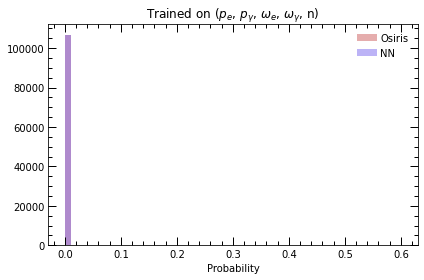

In [121]:
from matplotlib import pyplot
y0 = np.array(y0)
bins = np.linspace(0.0004, 0.6, 60)
pyplot.hist(y0, bins, color = 'indianred', alpha=0.5, label='Osiris')
pyplot.hist(y_pred0, bins, color = 'mediumslateblue', alpha=0.5, label='NN')
#pyplot.yscale('log')
pyplot.legend(loc='upper right')
pyplot.xlabel('Probability')
pyplot.title('Trained on ($p_e$, $p_{\gamma}$, $\omega_e$, $\omega_{\gamma}$, n)')
pyplot.show()

In [122]:
y1 = class_data_high1[:,0]
x1 = class_data_high1[:,1:9]

In [123]:
y1

array([0.00112653, 0.00176309, 0.00106408, ..., 0.00154134, 0.00142122,
       0.00103812])

In [127]:
y_pred1 = model.predict(x1)

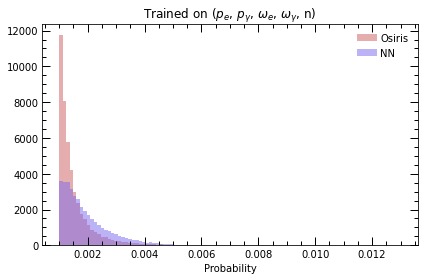

In [129]:
from matplotlib import pyplot
y1 = np.array(y1)
bins = np.linspace(0.001, 0.013, 100)
pyplot.hist(y1, bins, color = 'indianred', alpha=0.5, label='Osiris')
pyplot.hist(y_pred1, bins, color = 'mediumslateblue', alpha=0.5, label='NN')
#pyplot.yscale('log')
pyplot.legend(loc='upper right')
pyplot.xlabel('Probability')
pyplot.title('Trained on ($p_e$, $p_{\gamma}$, $\omega_e$, $\omega_{\gamma}$, n)')
pyplot.show()